./50ns_no_ramp_thermo_data/2beg_0.00_1.0_3101.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_3501.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_4001.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_4501.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_5001.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_5501.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_6001.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_6501.csv
./50ns_no_ramp_thermo_data/2beg_0.00_1.0_7001.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_3101.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_3501.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_4001.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_4501.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_5001.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_5501.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_6001.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_6501.csv
./50ns_no_ramp_thermo_data/2beg_0.05_1.0_7001.csv
./50ns_no_ramp_thermo_data/2beg_0.1_1.0_3101.csv
./50ns_no_ramp_thermo_data/2beg_0.1_1.0_3501.csv
./

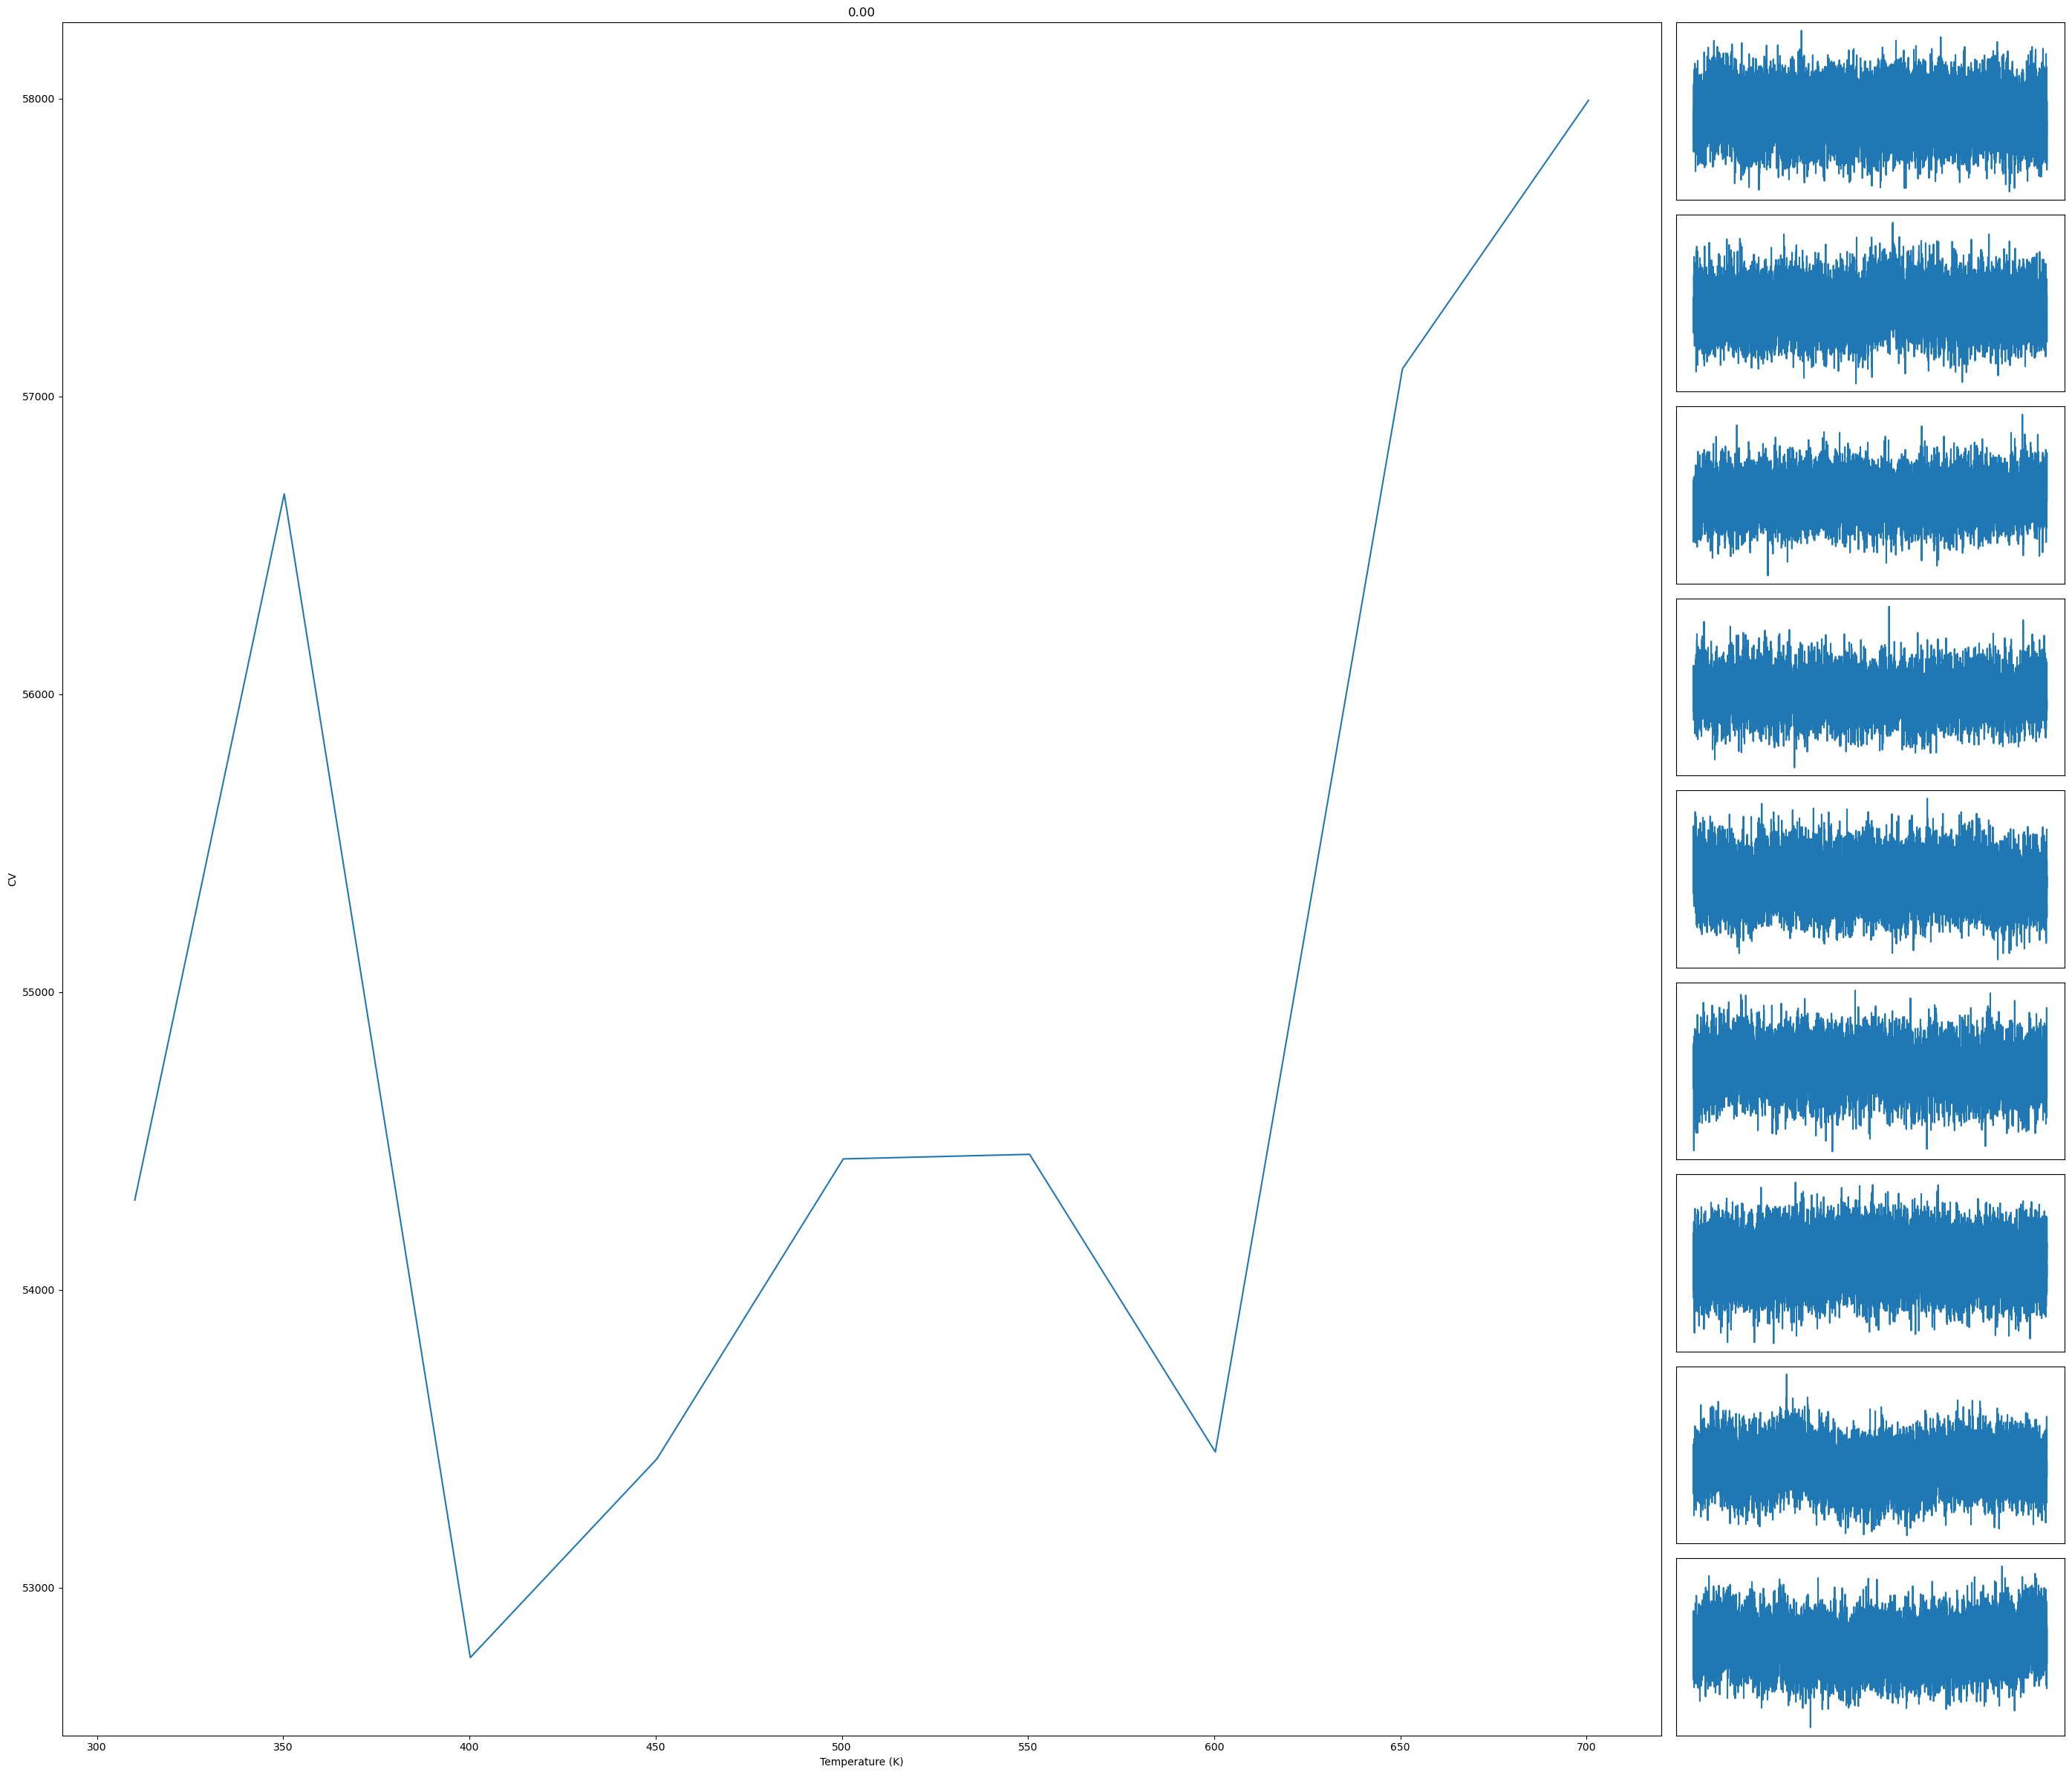

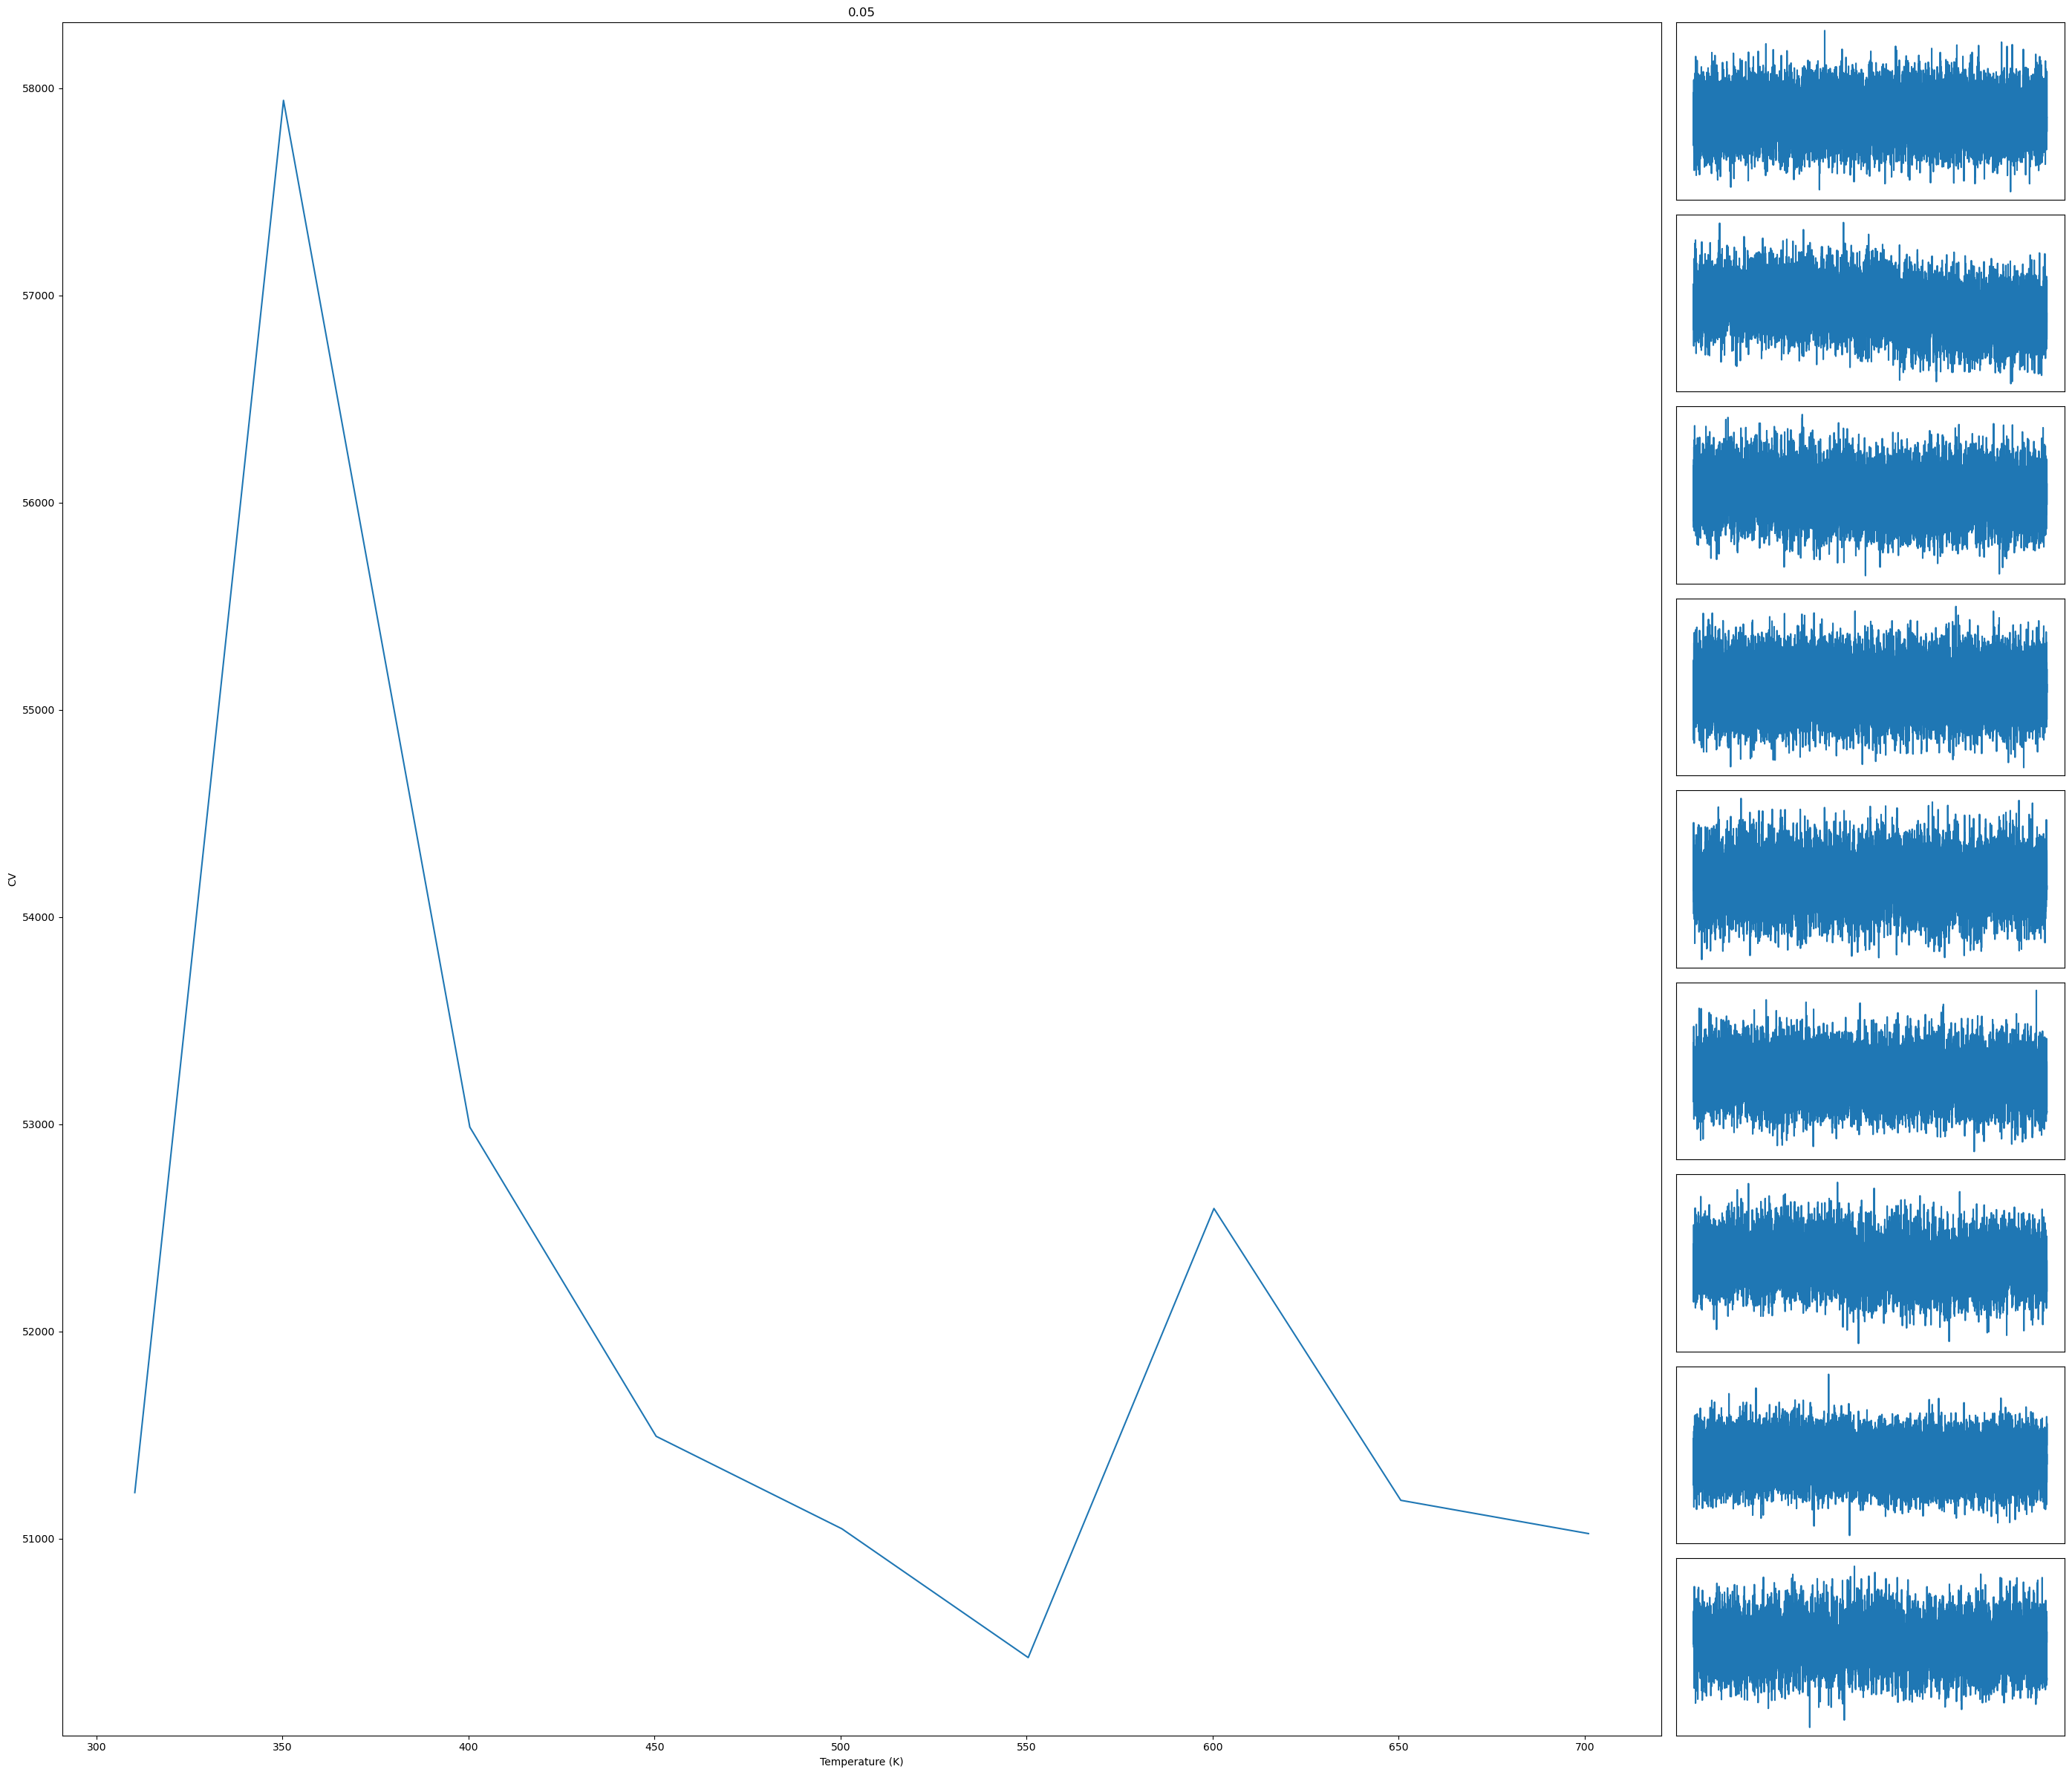

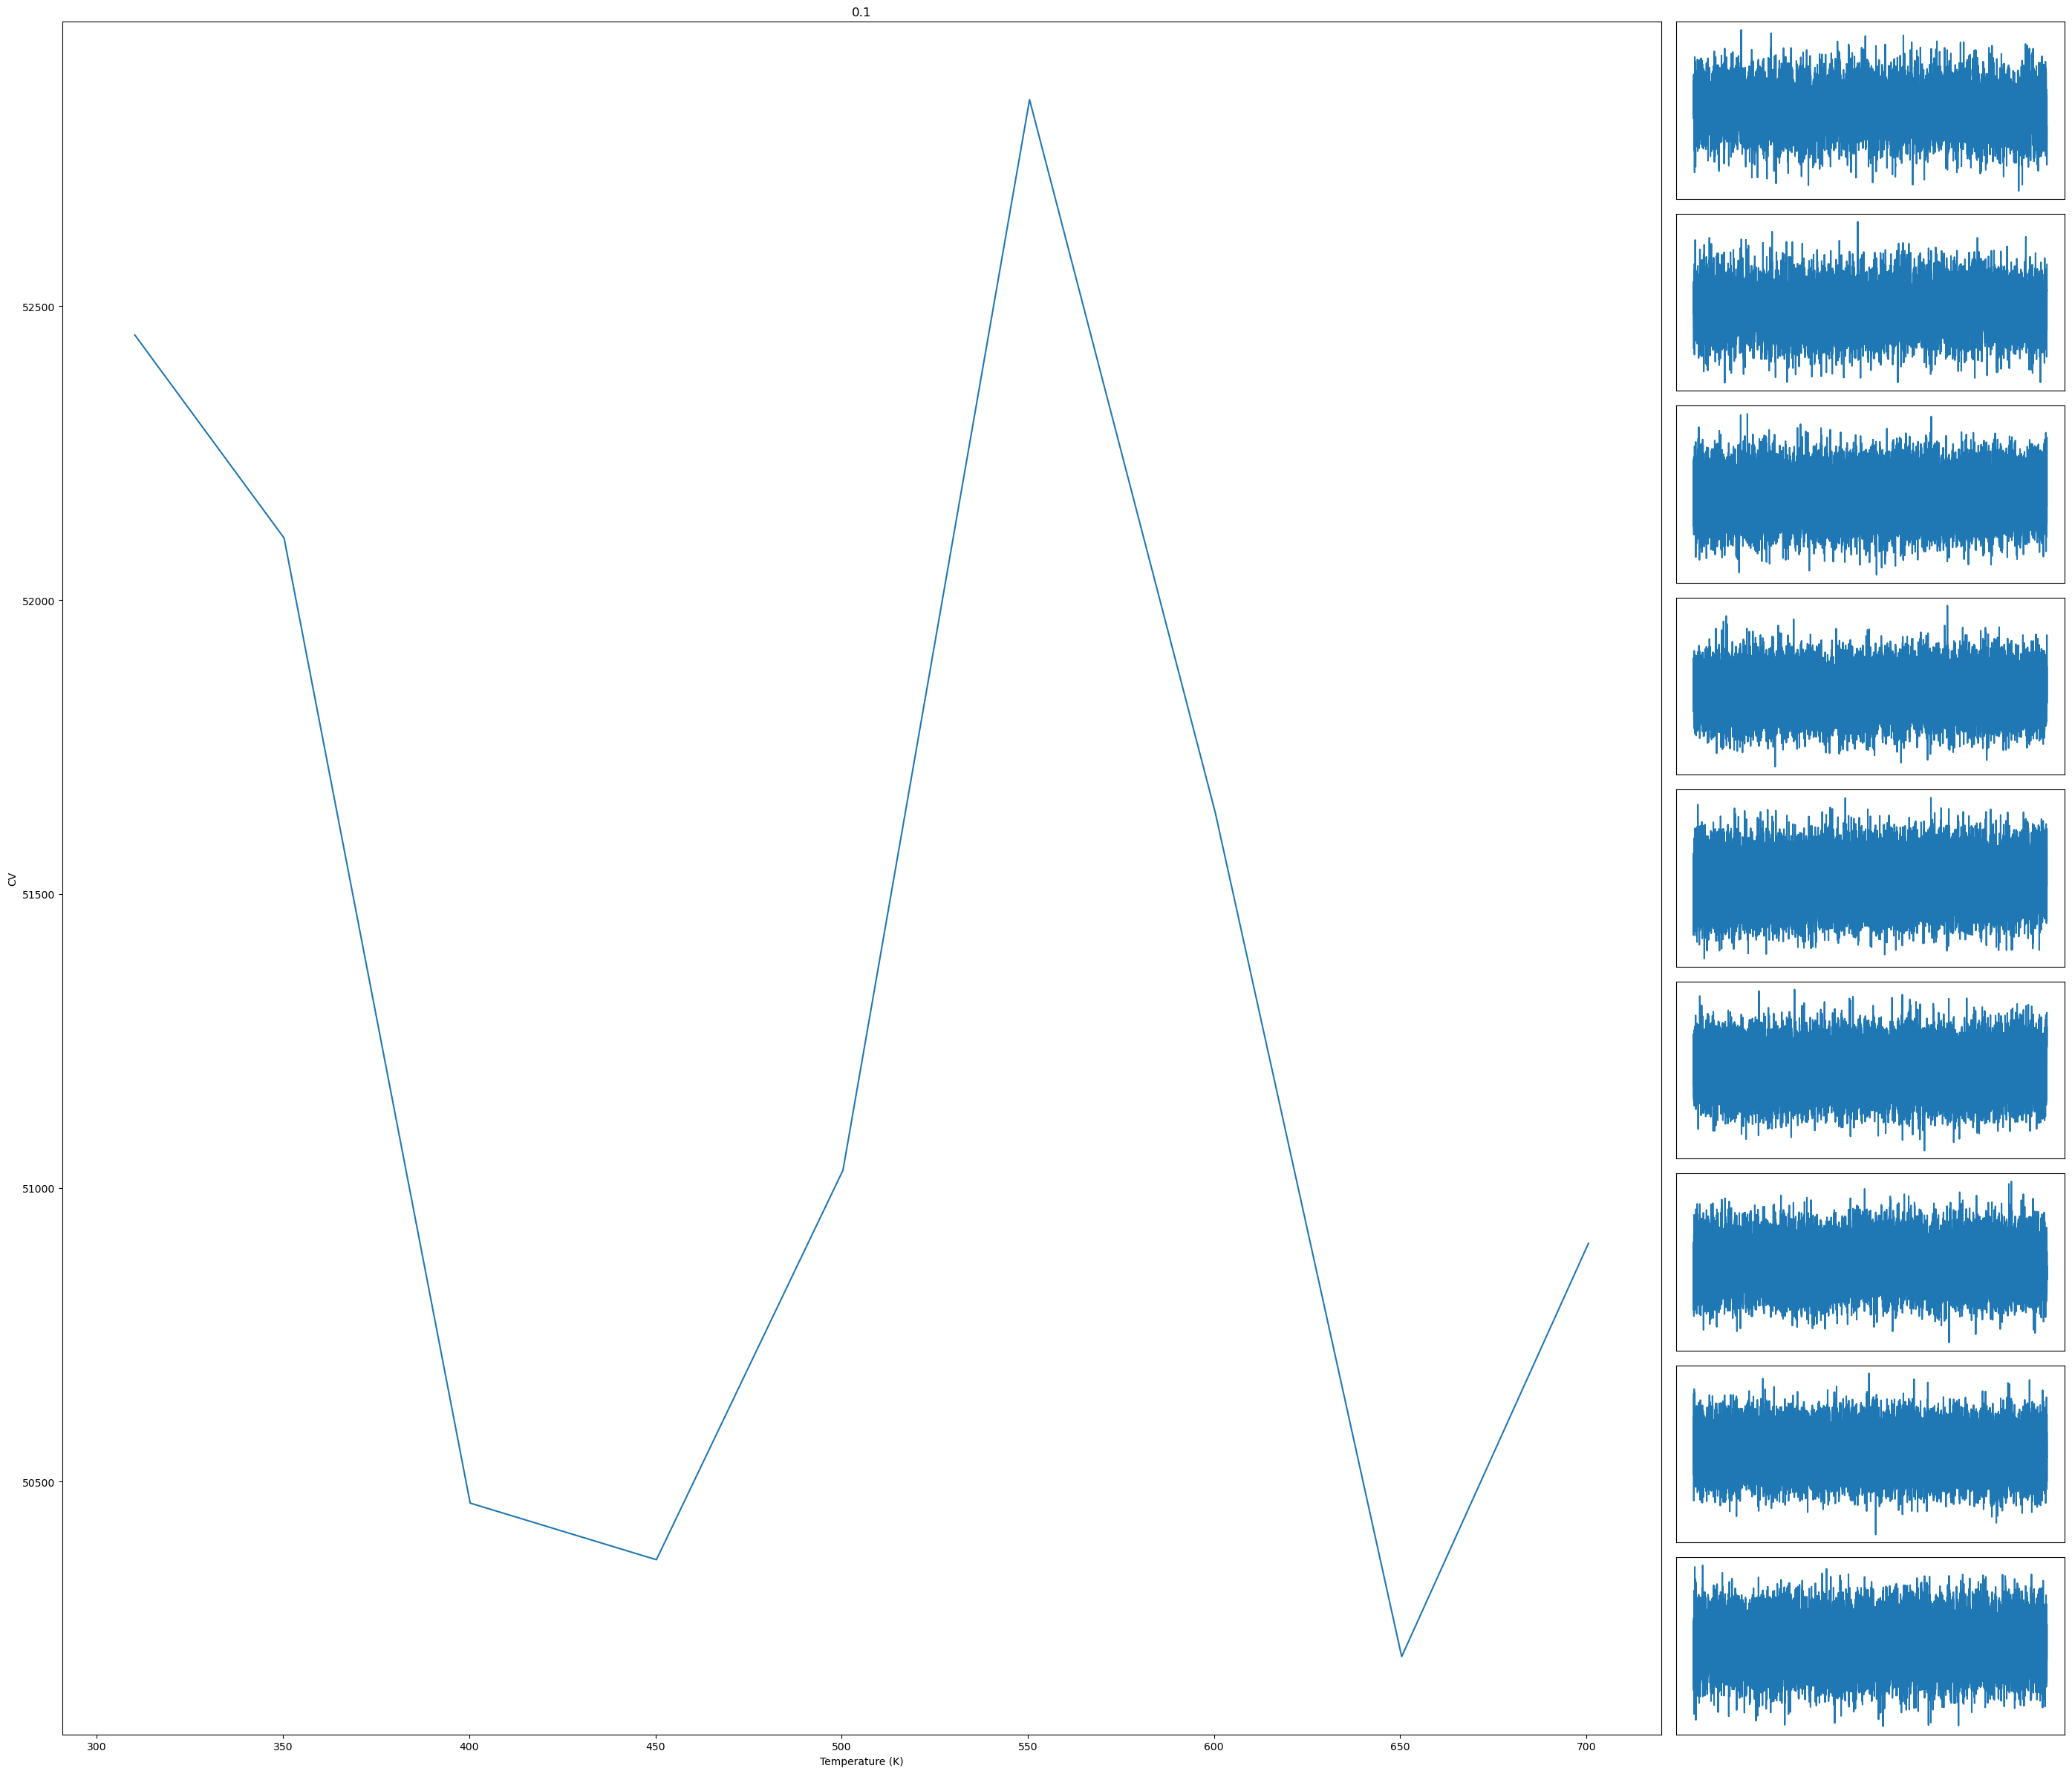

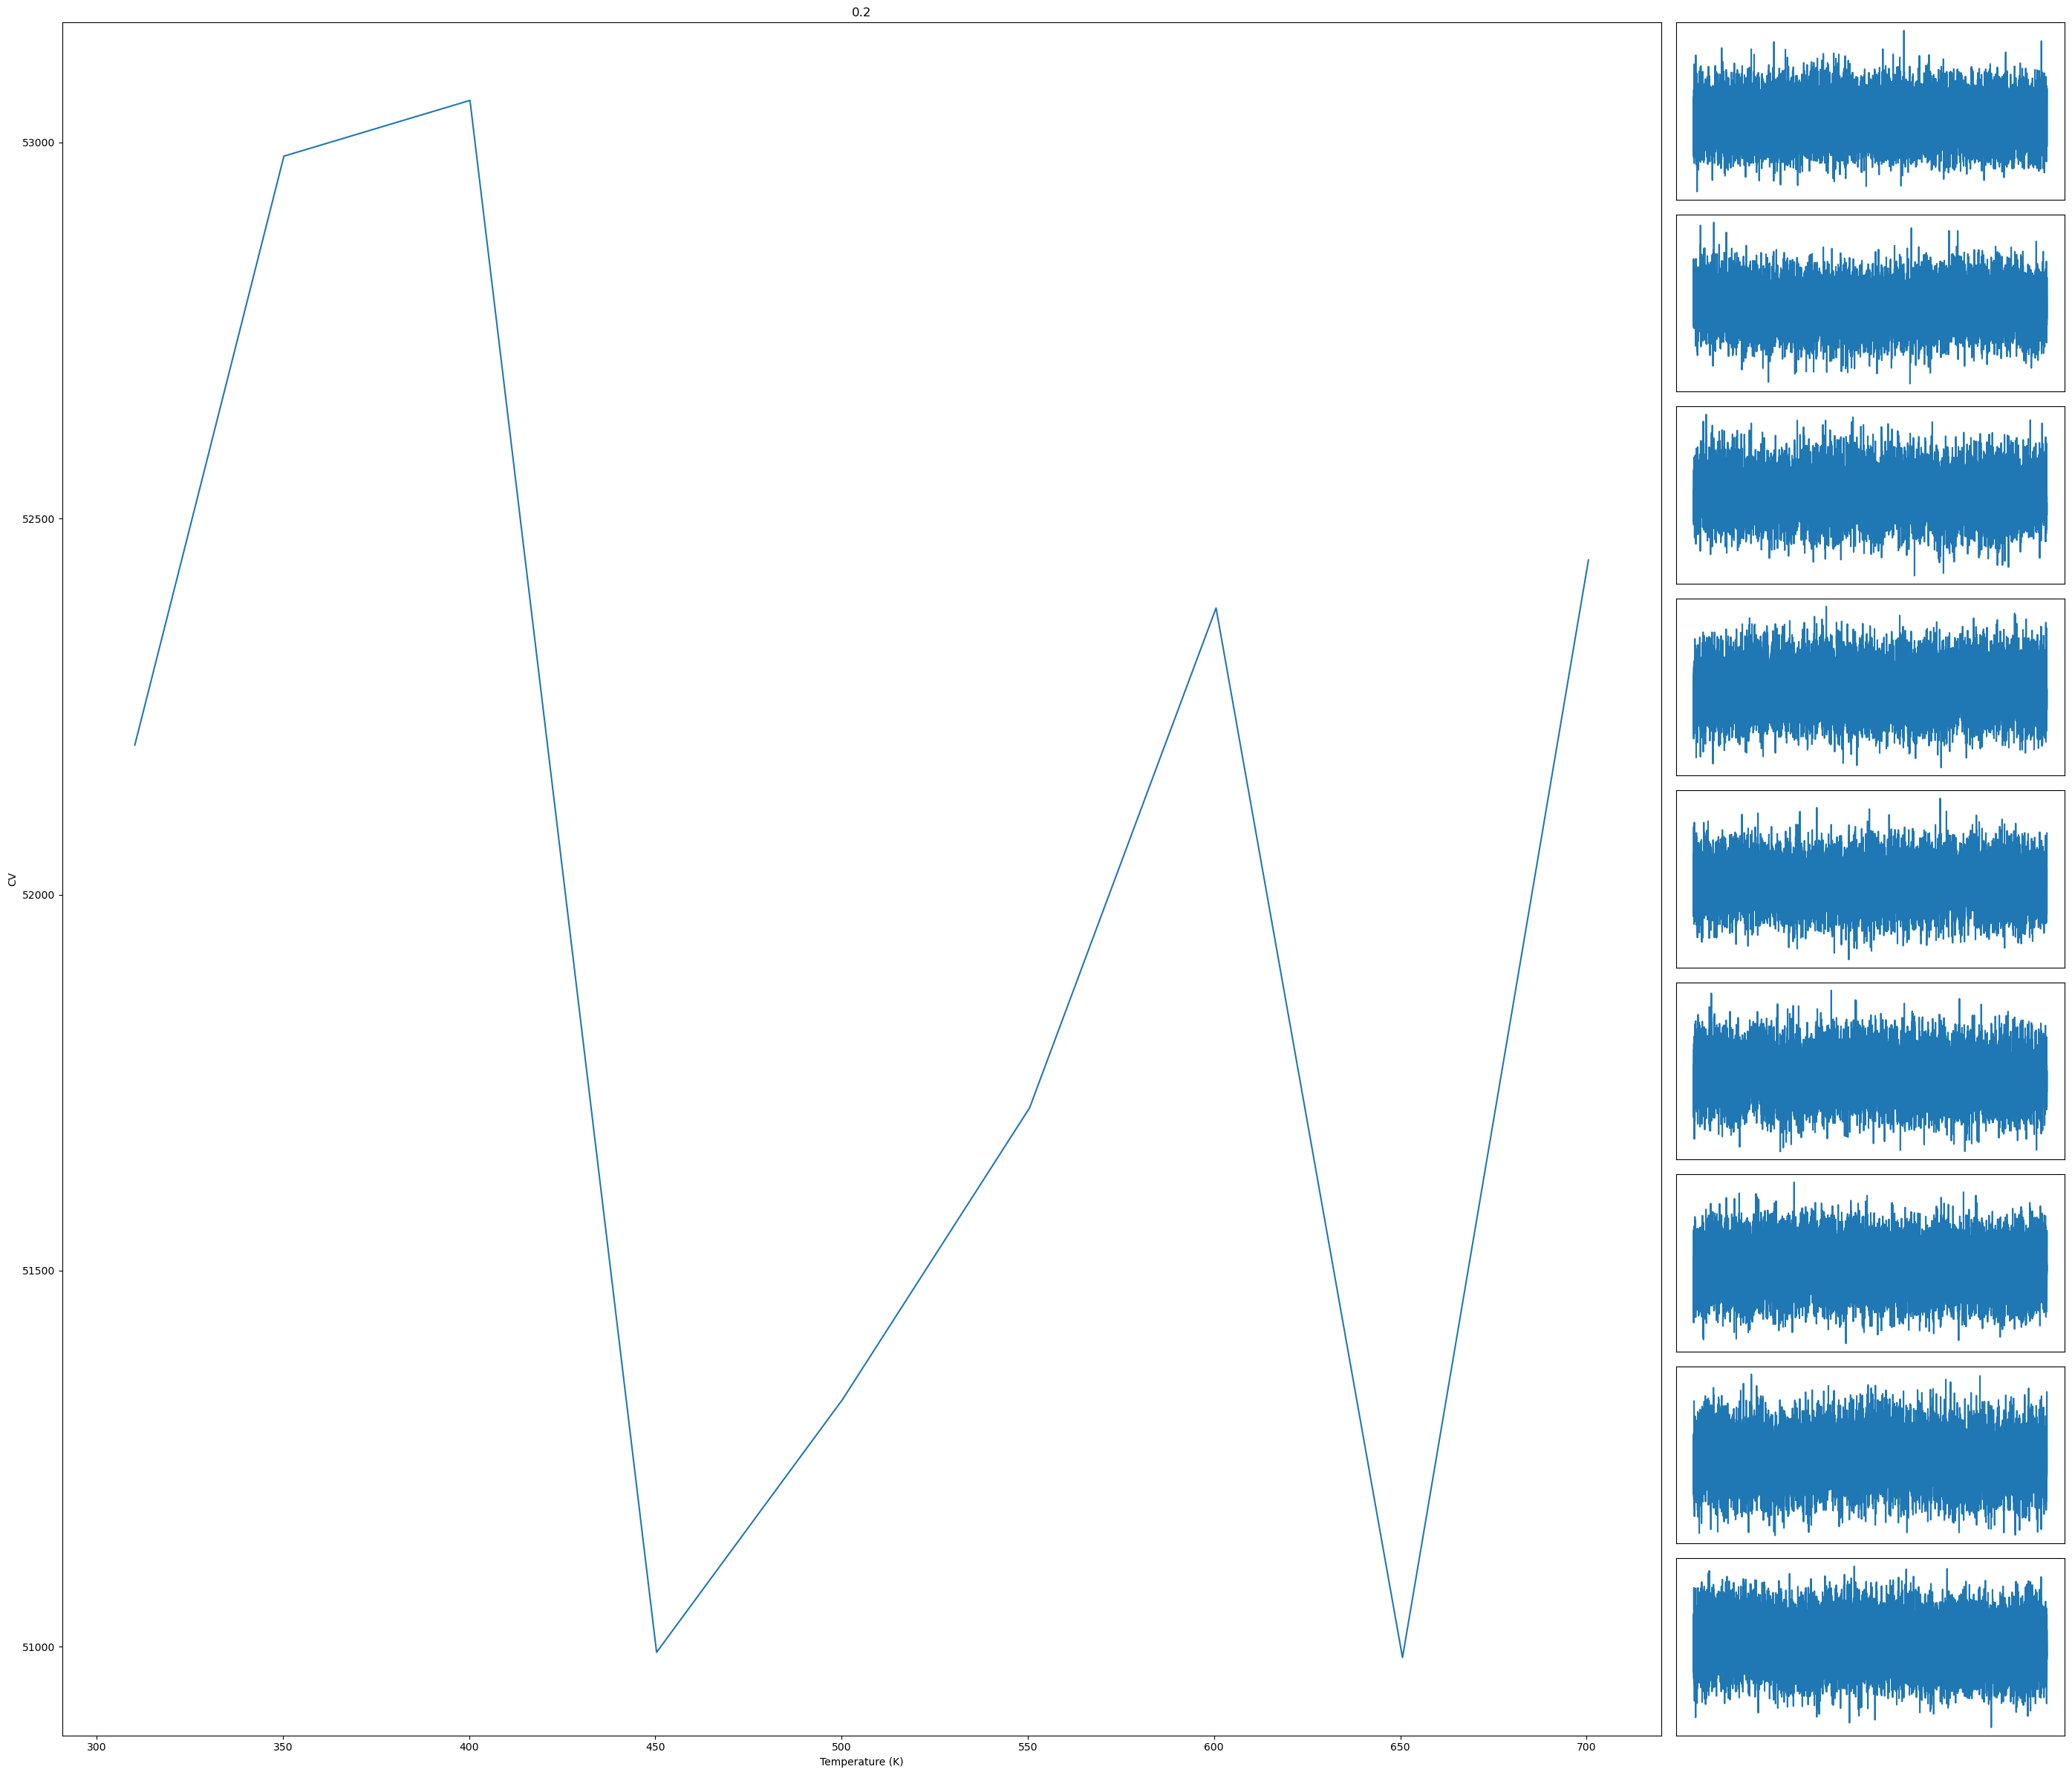

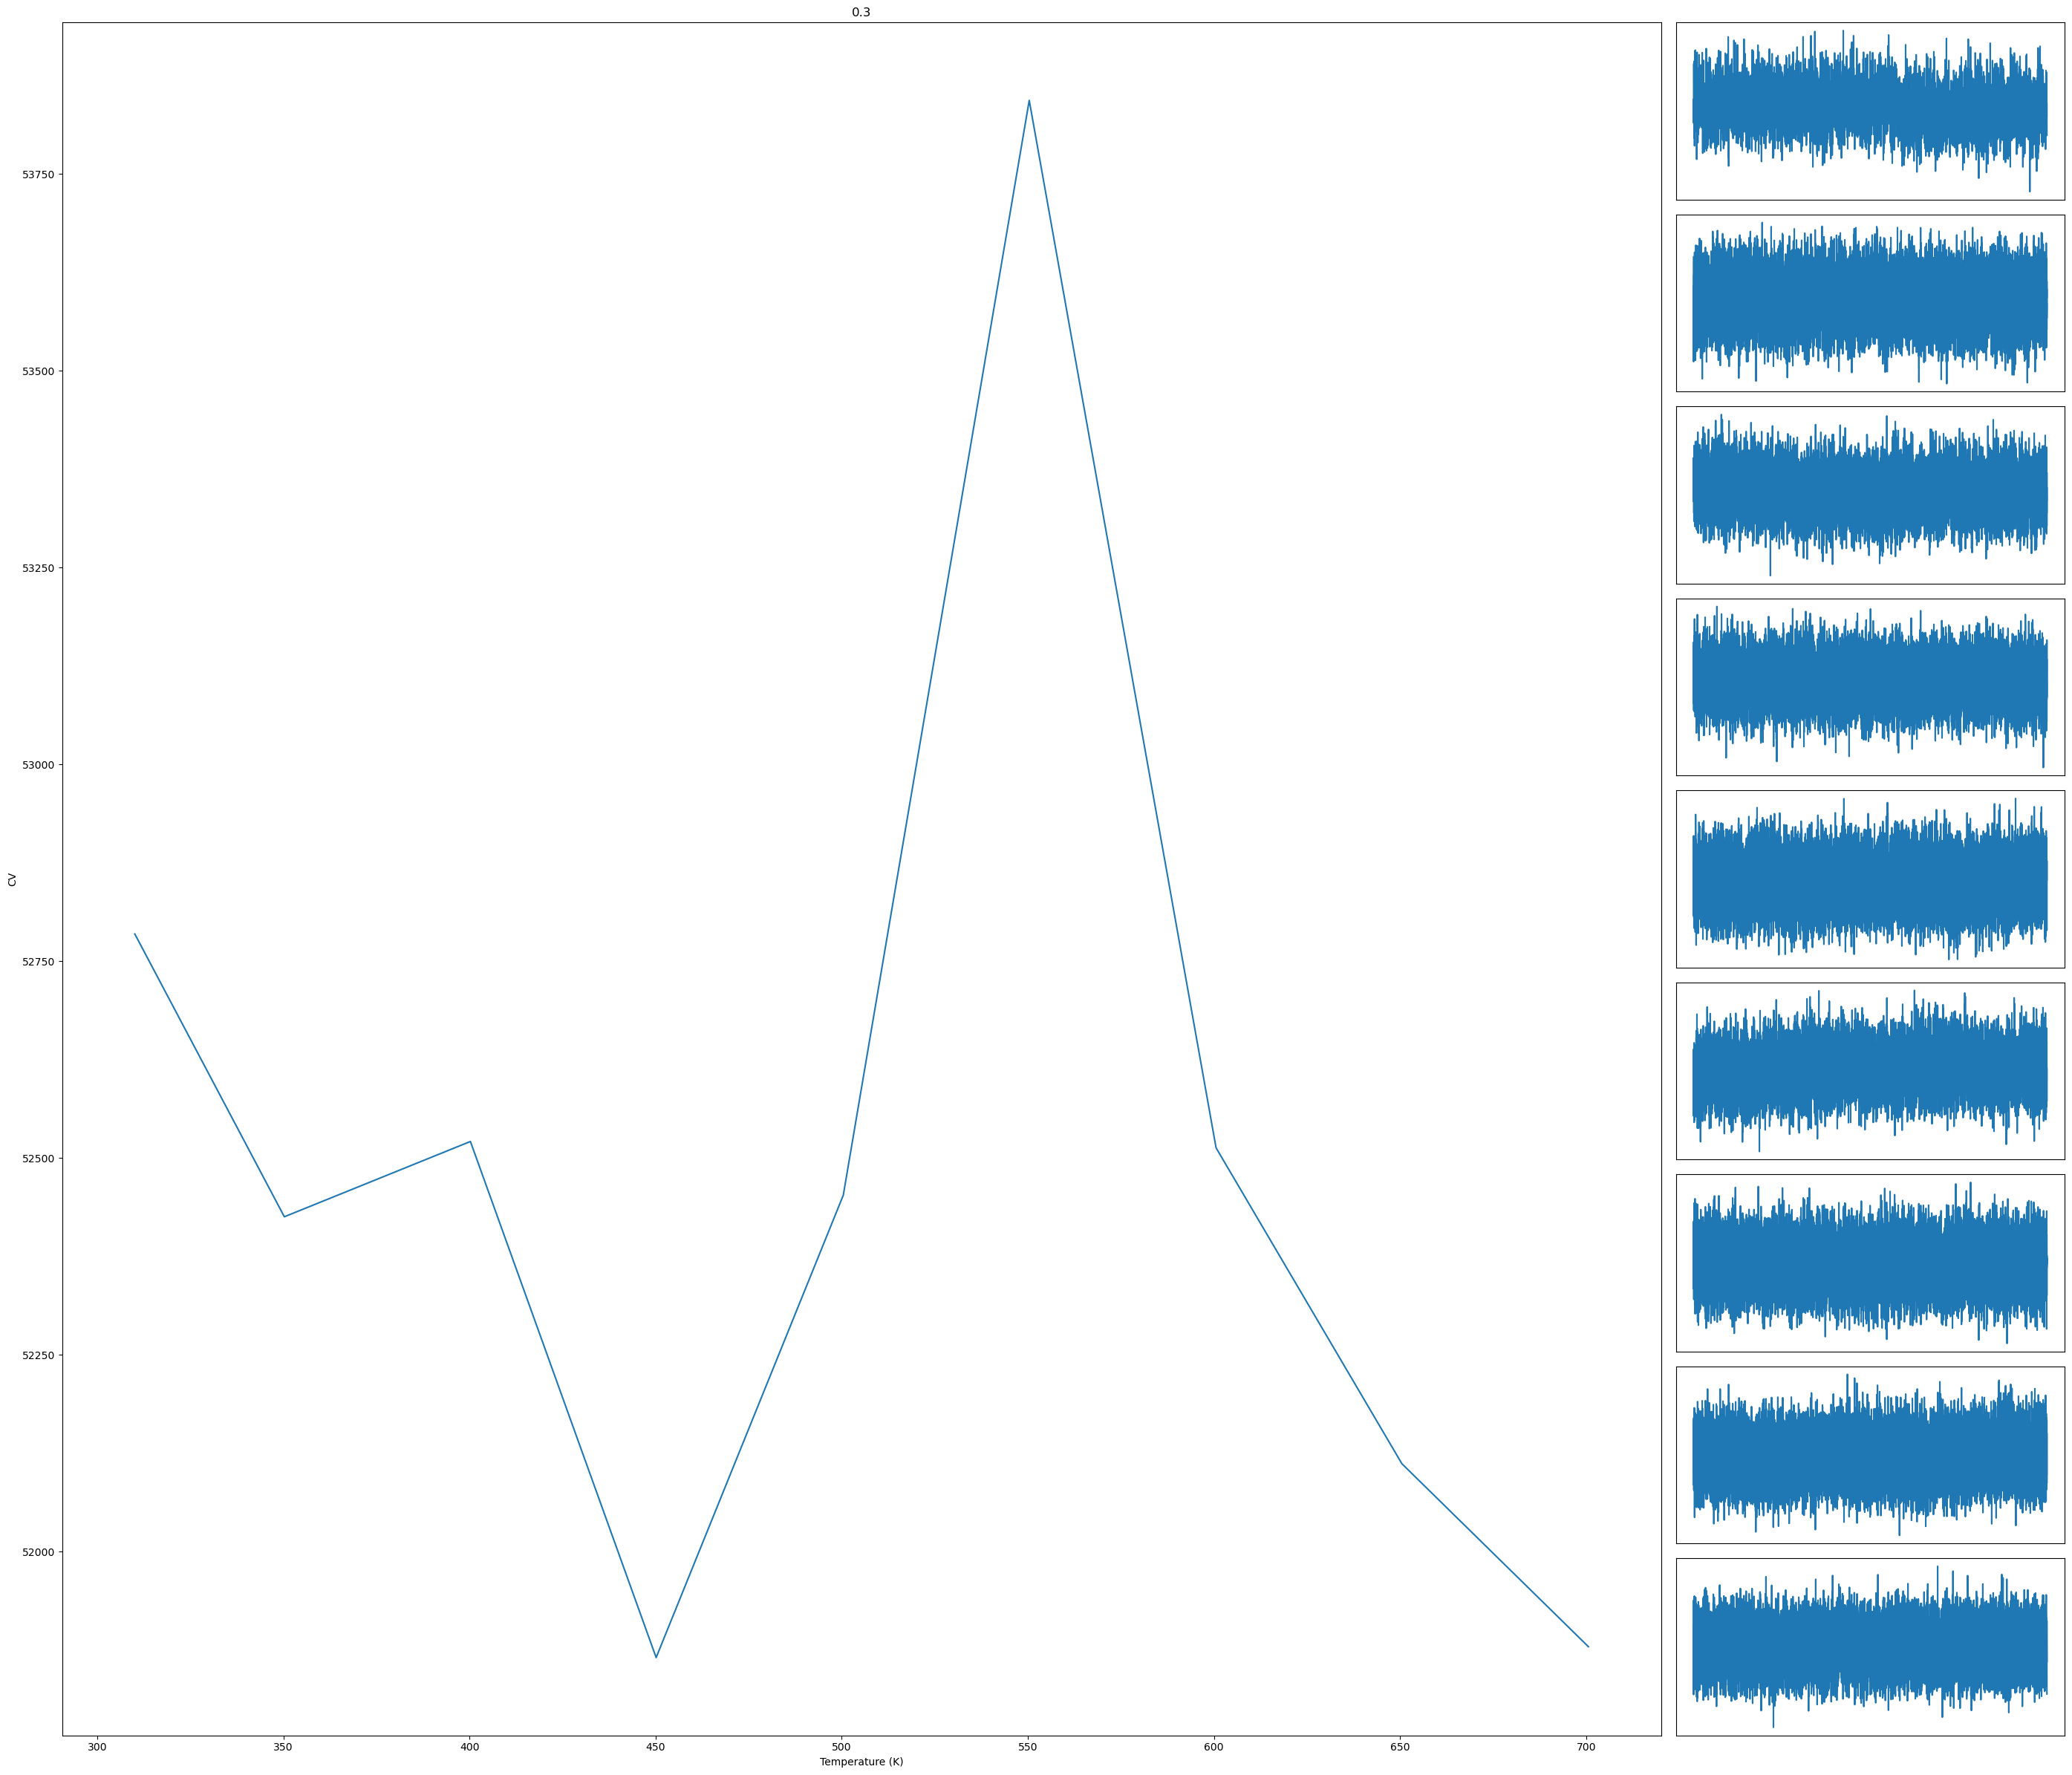

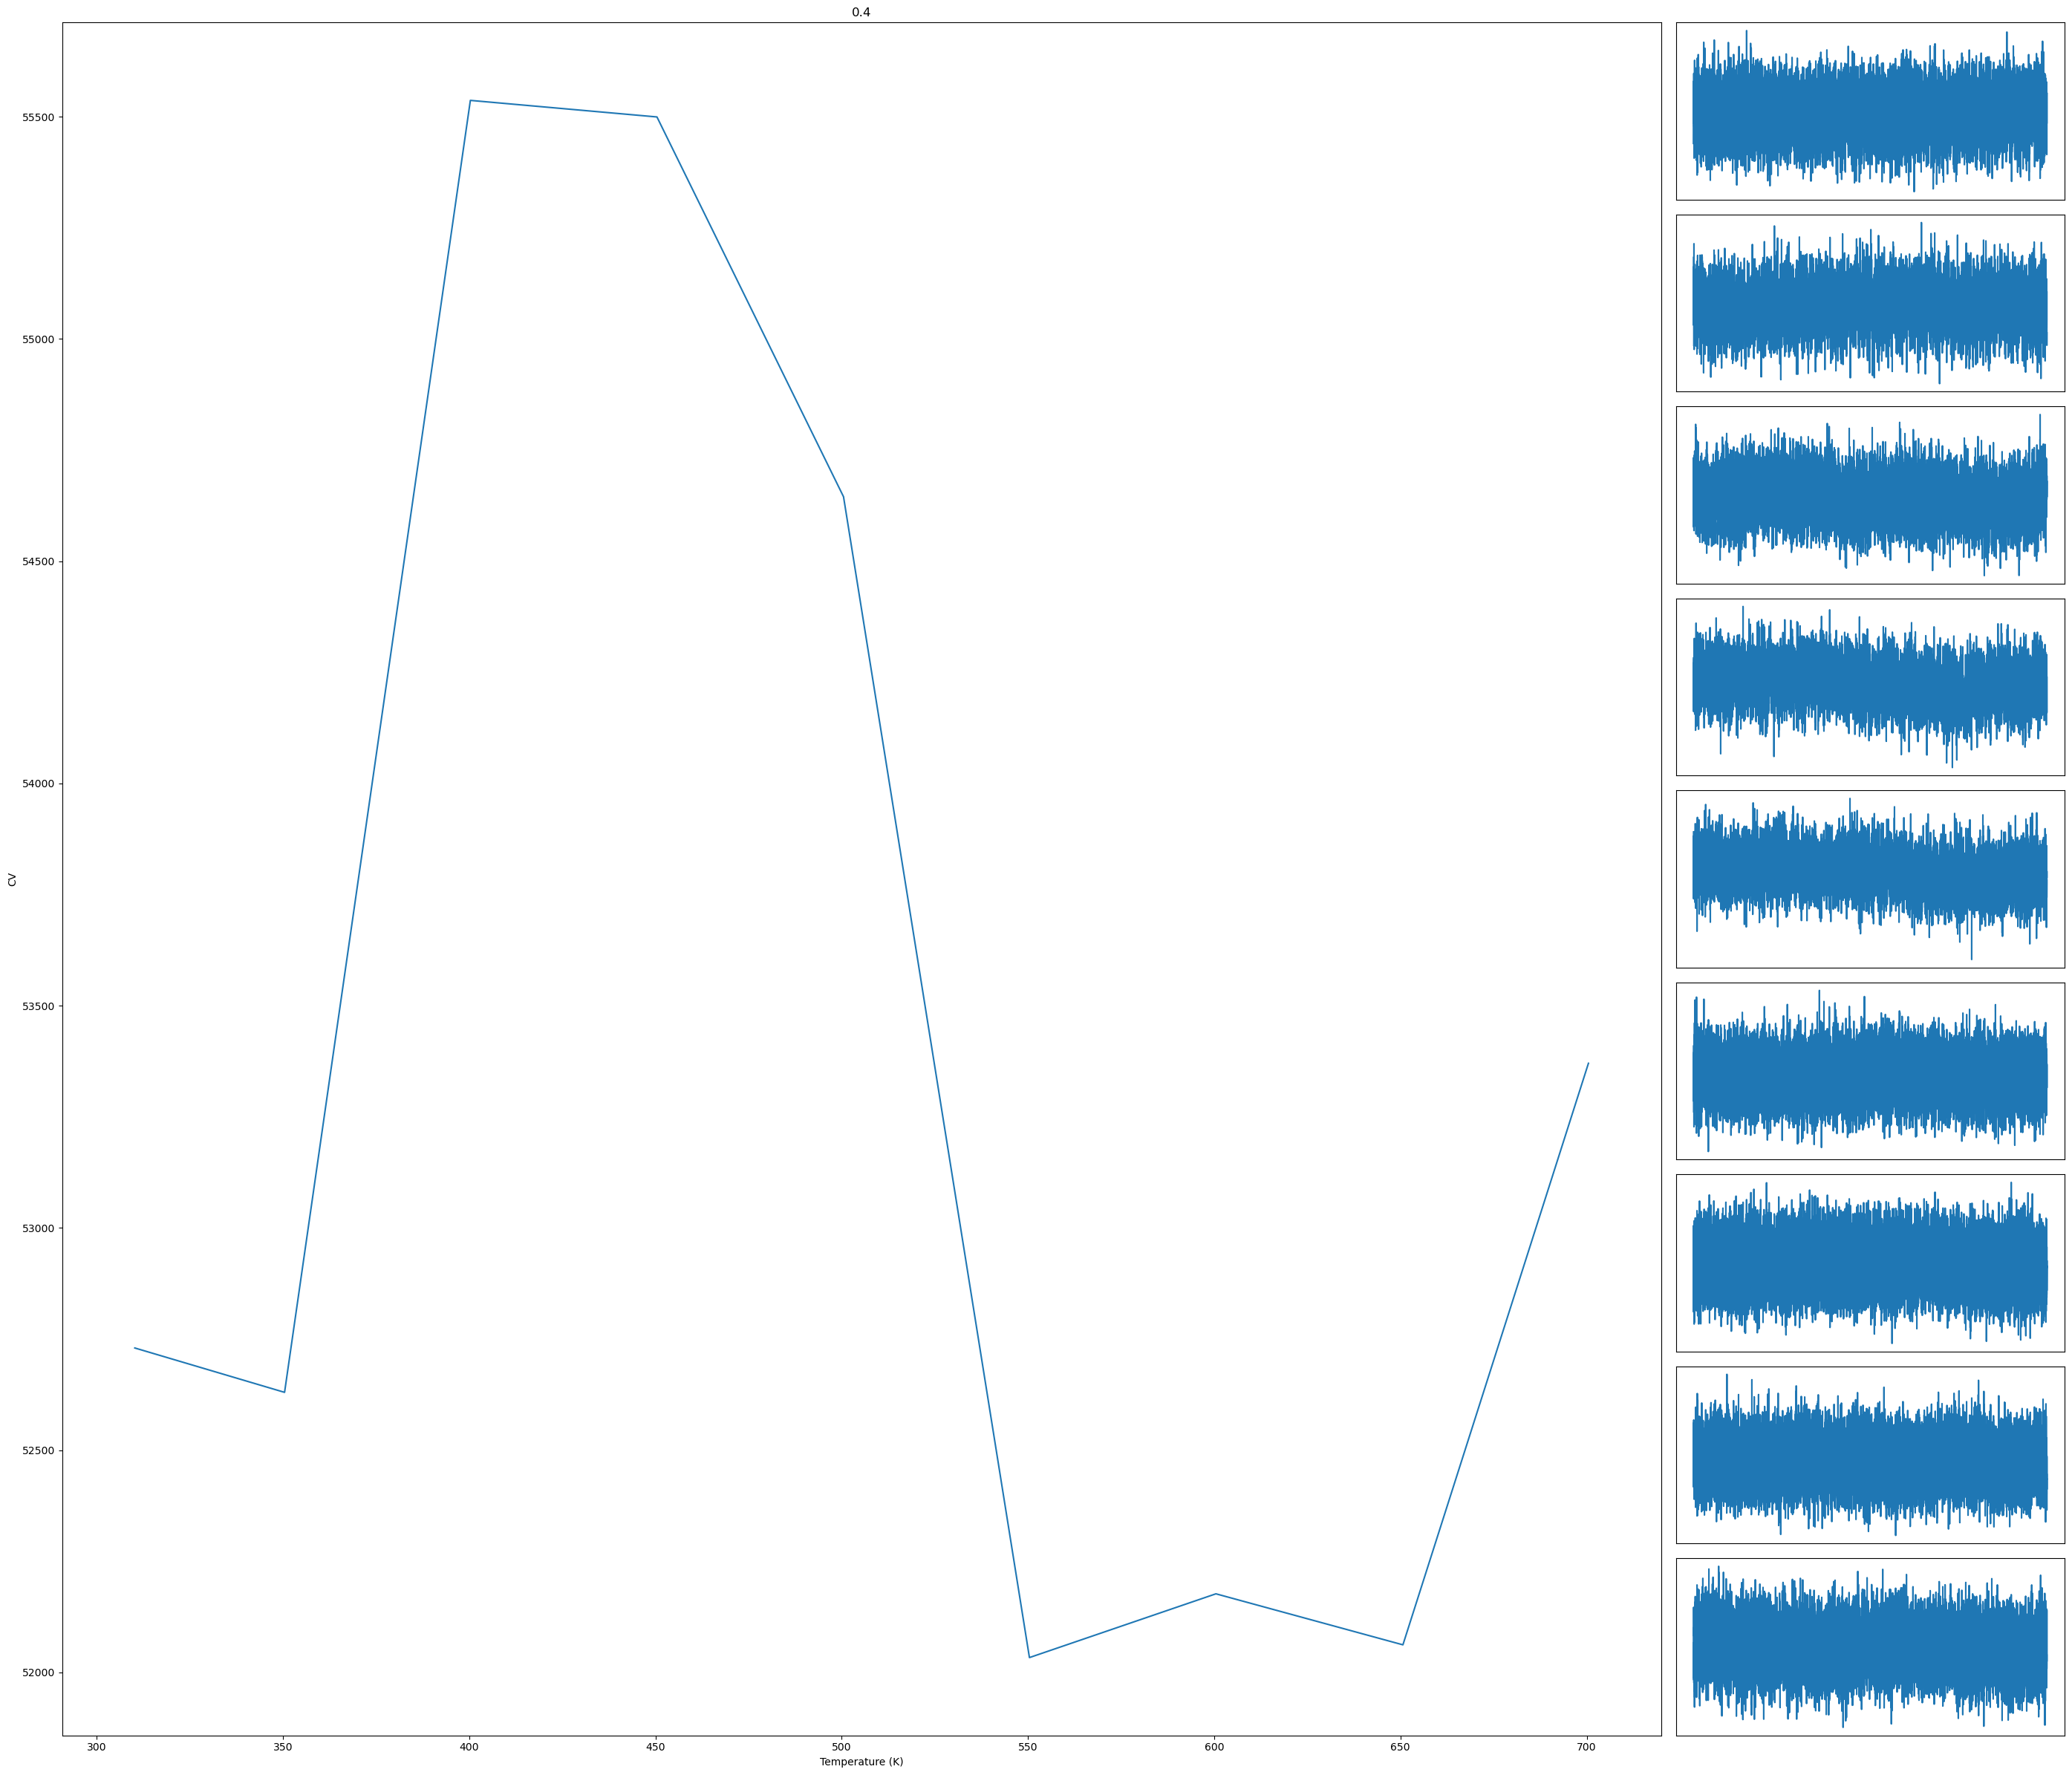

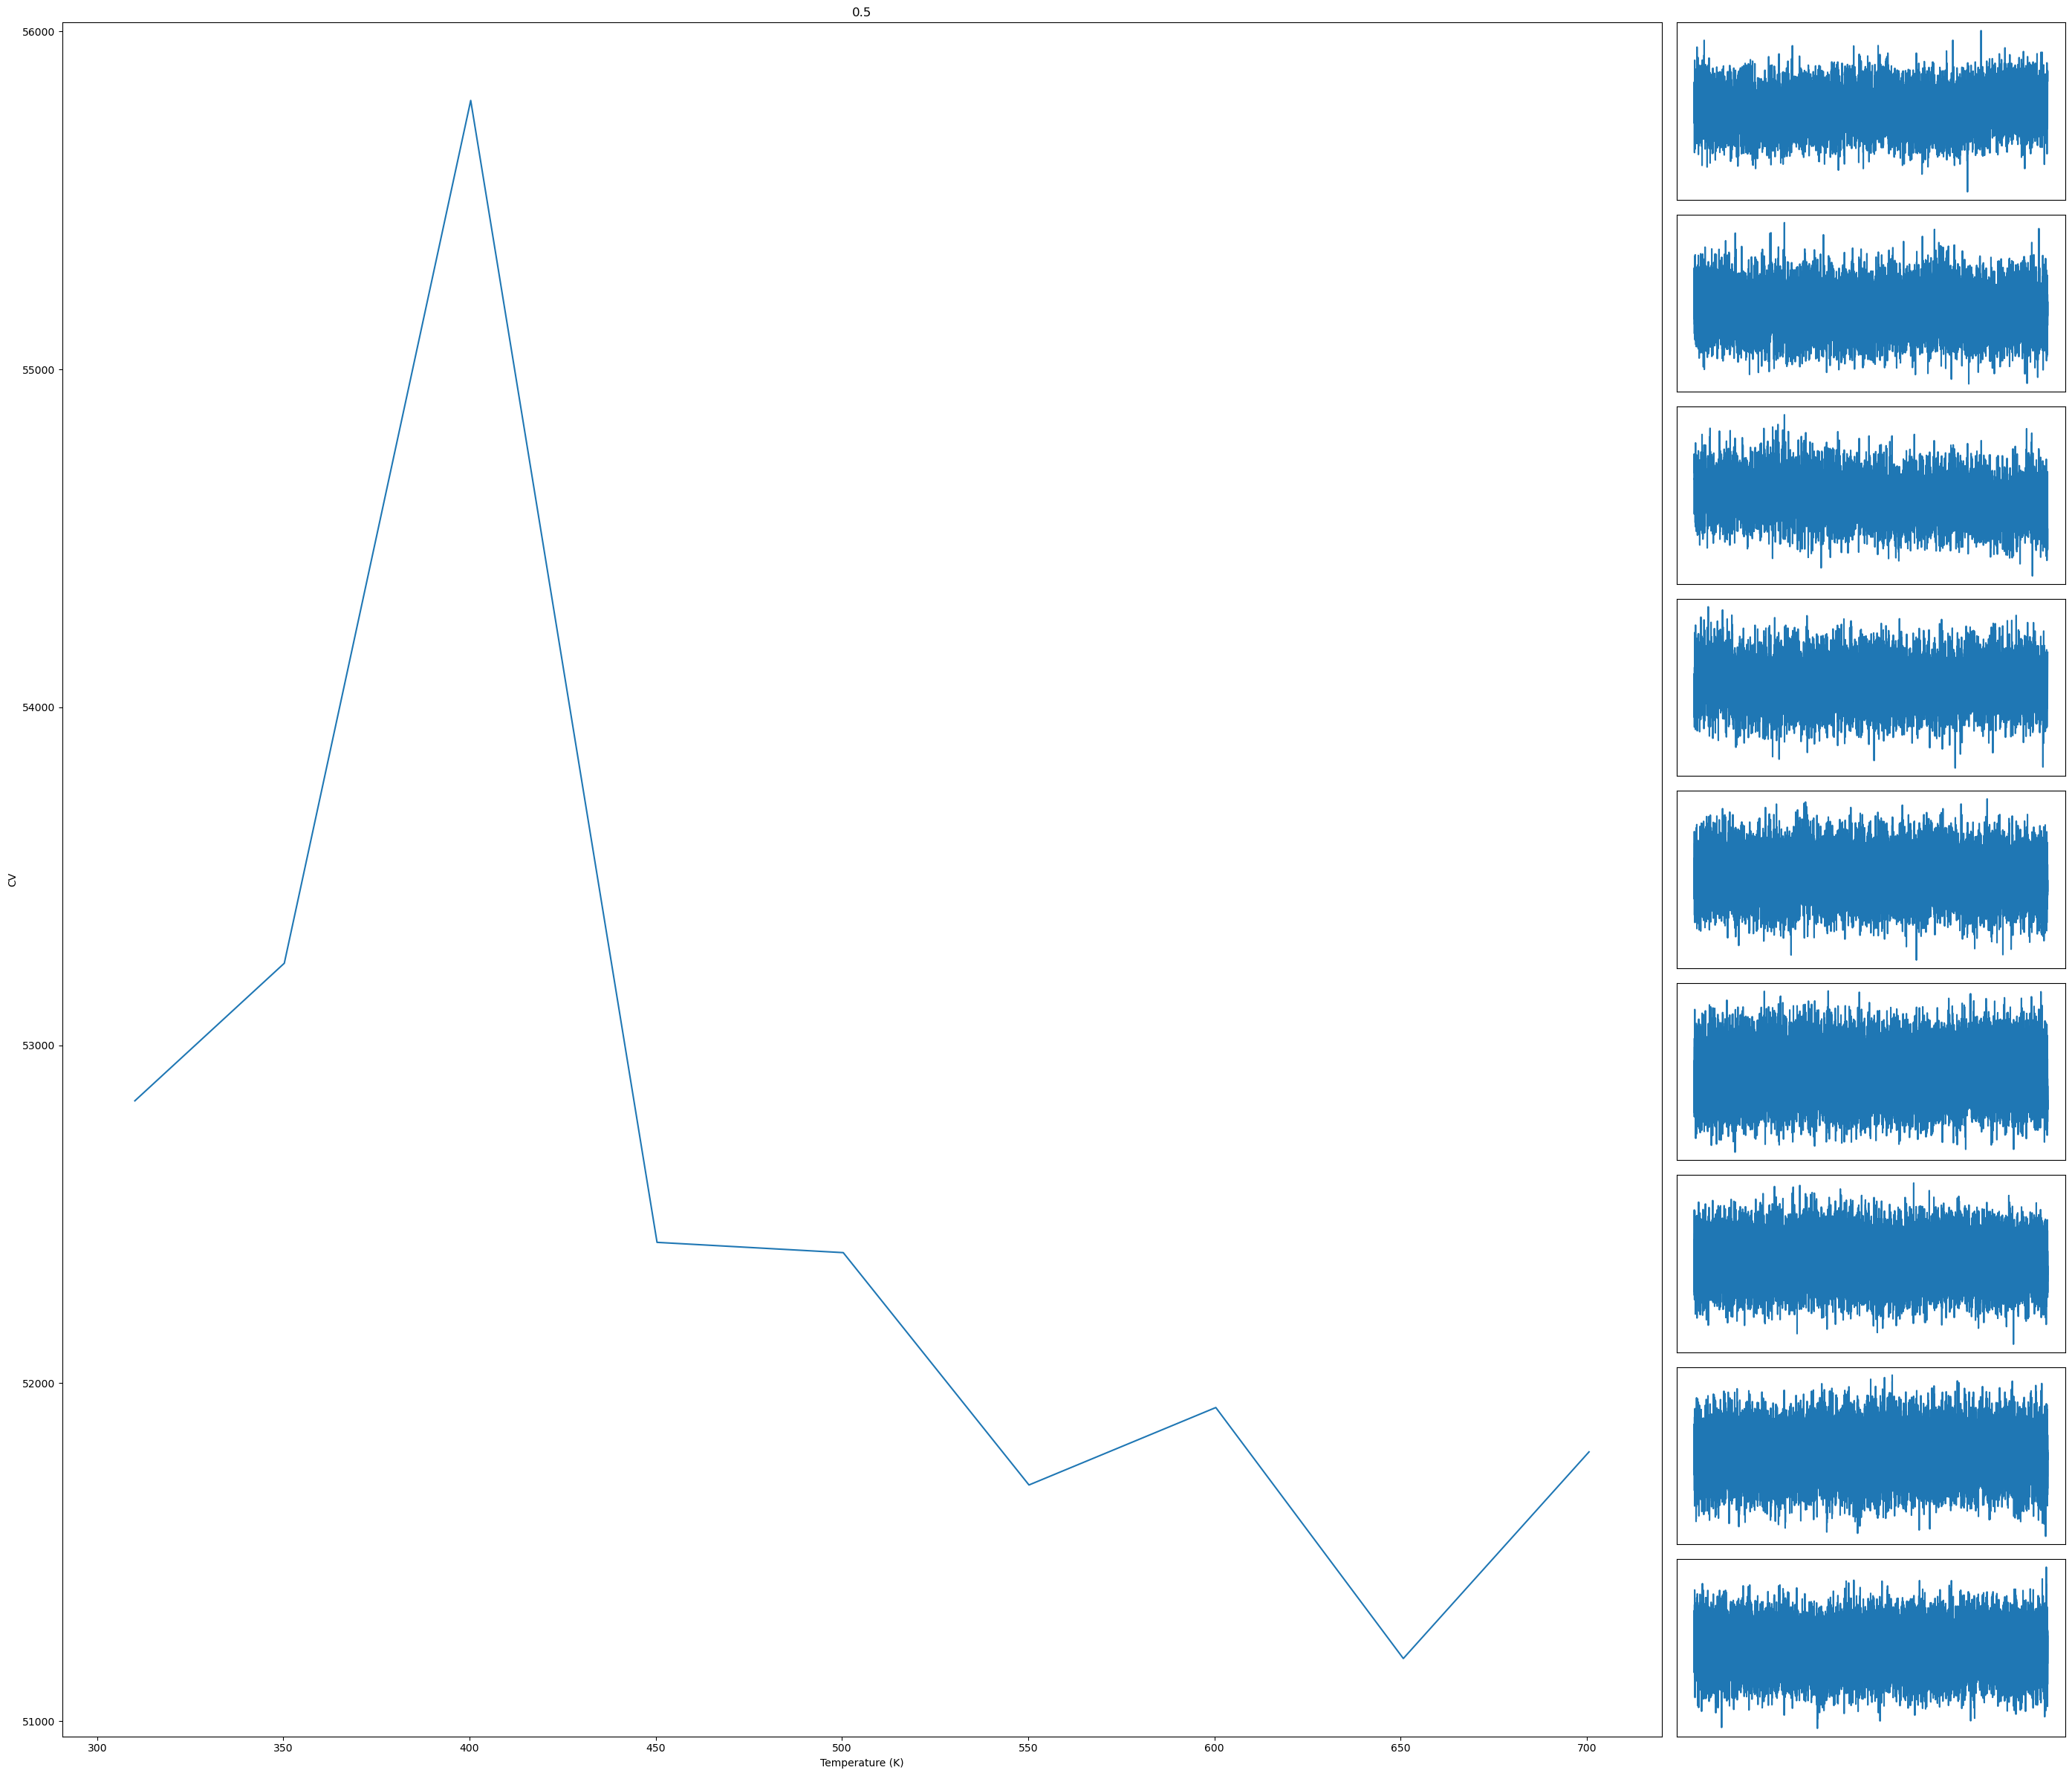

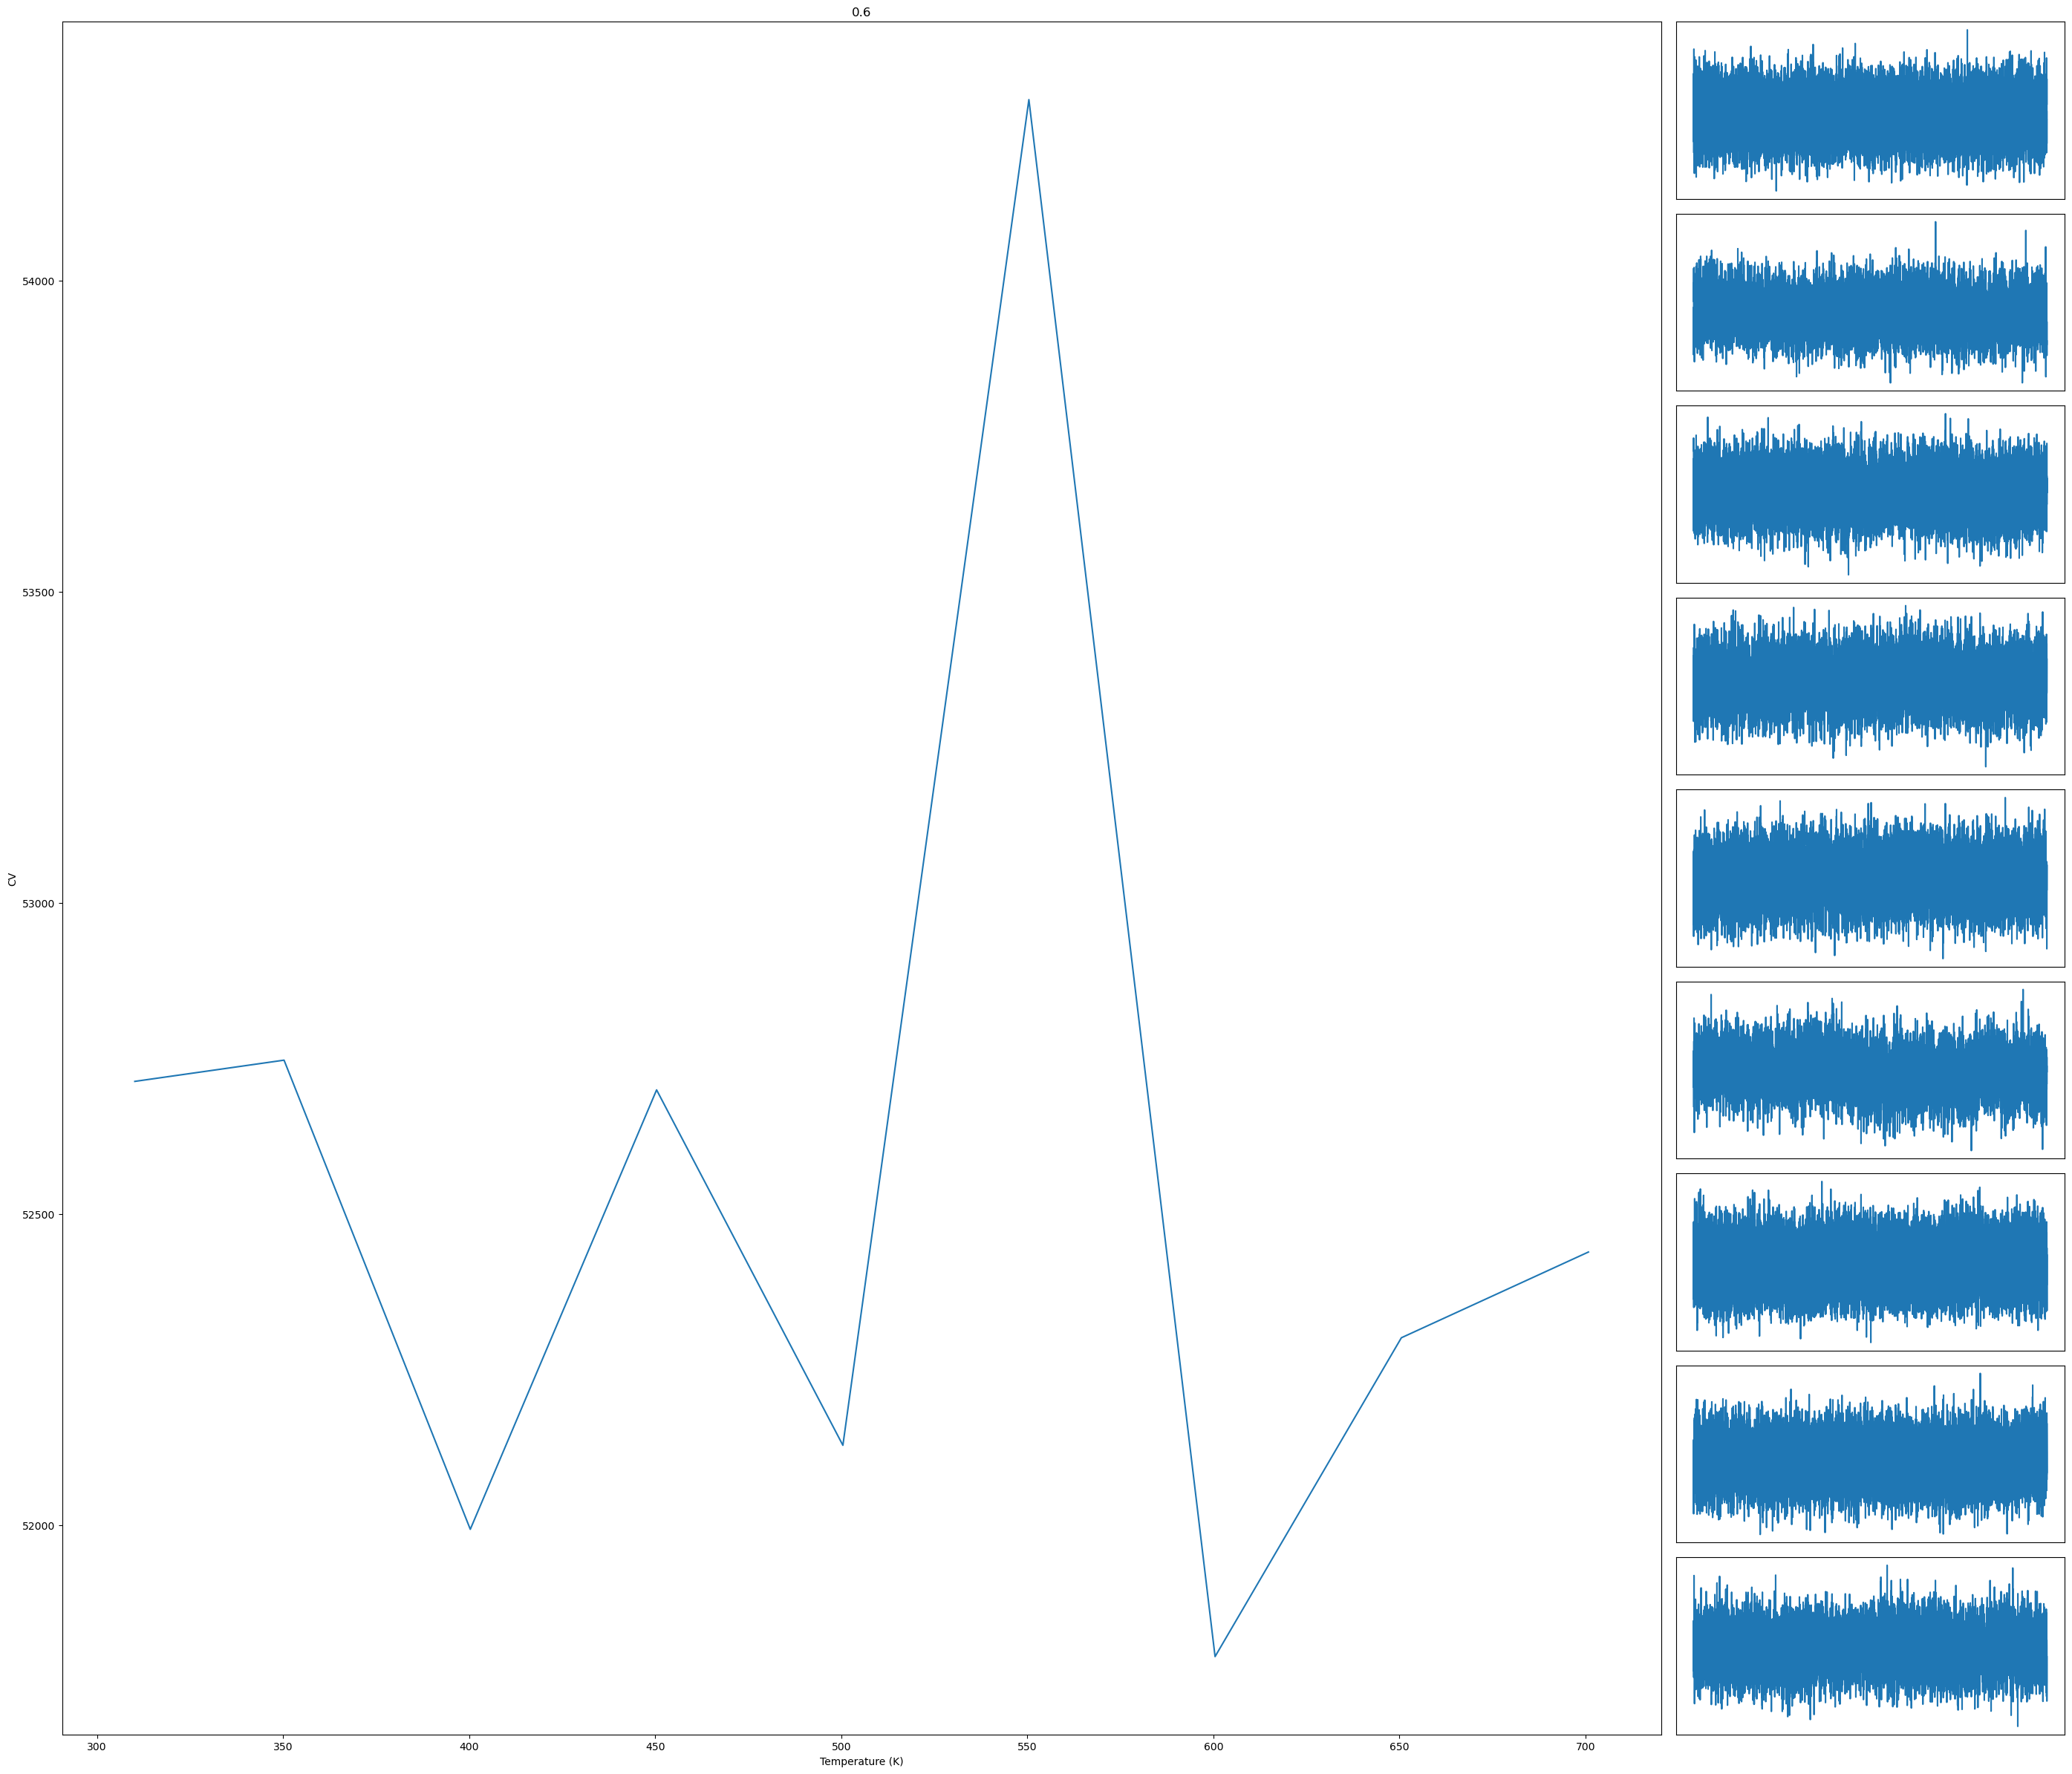

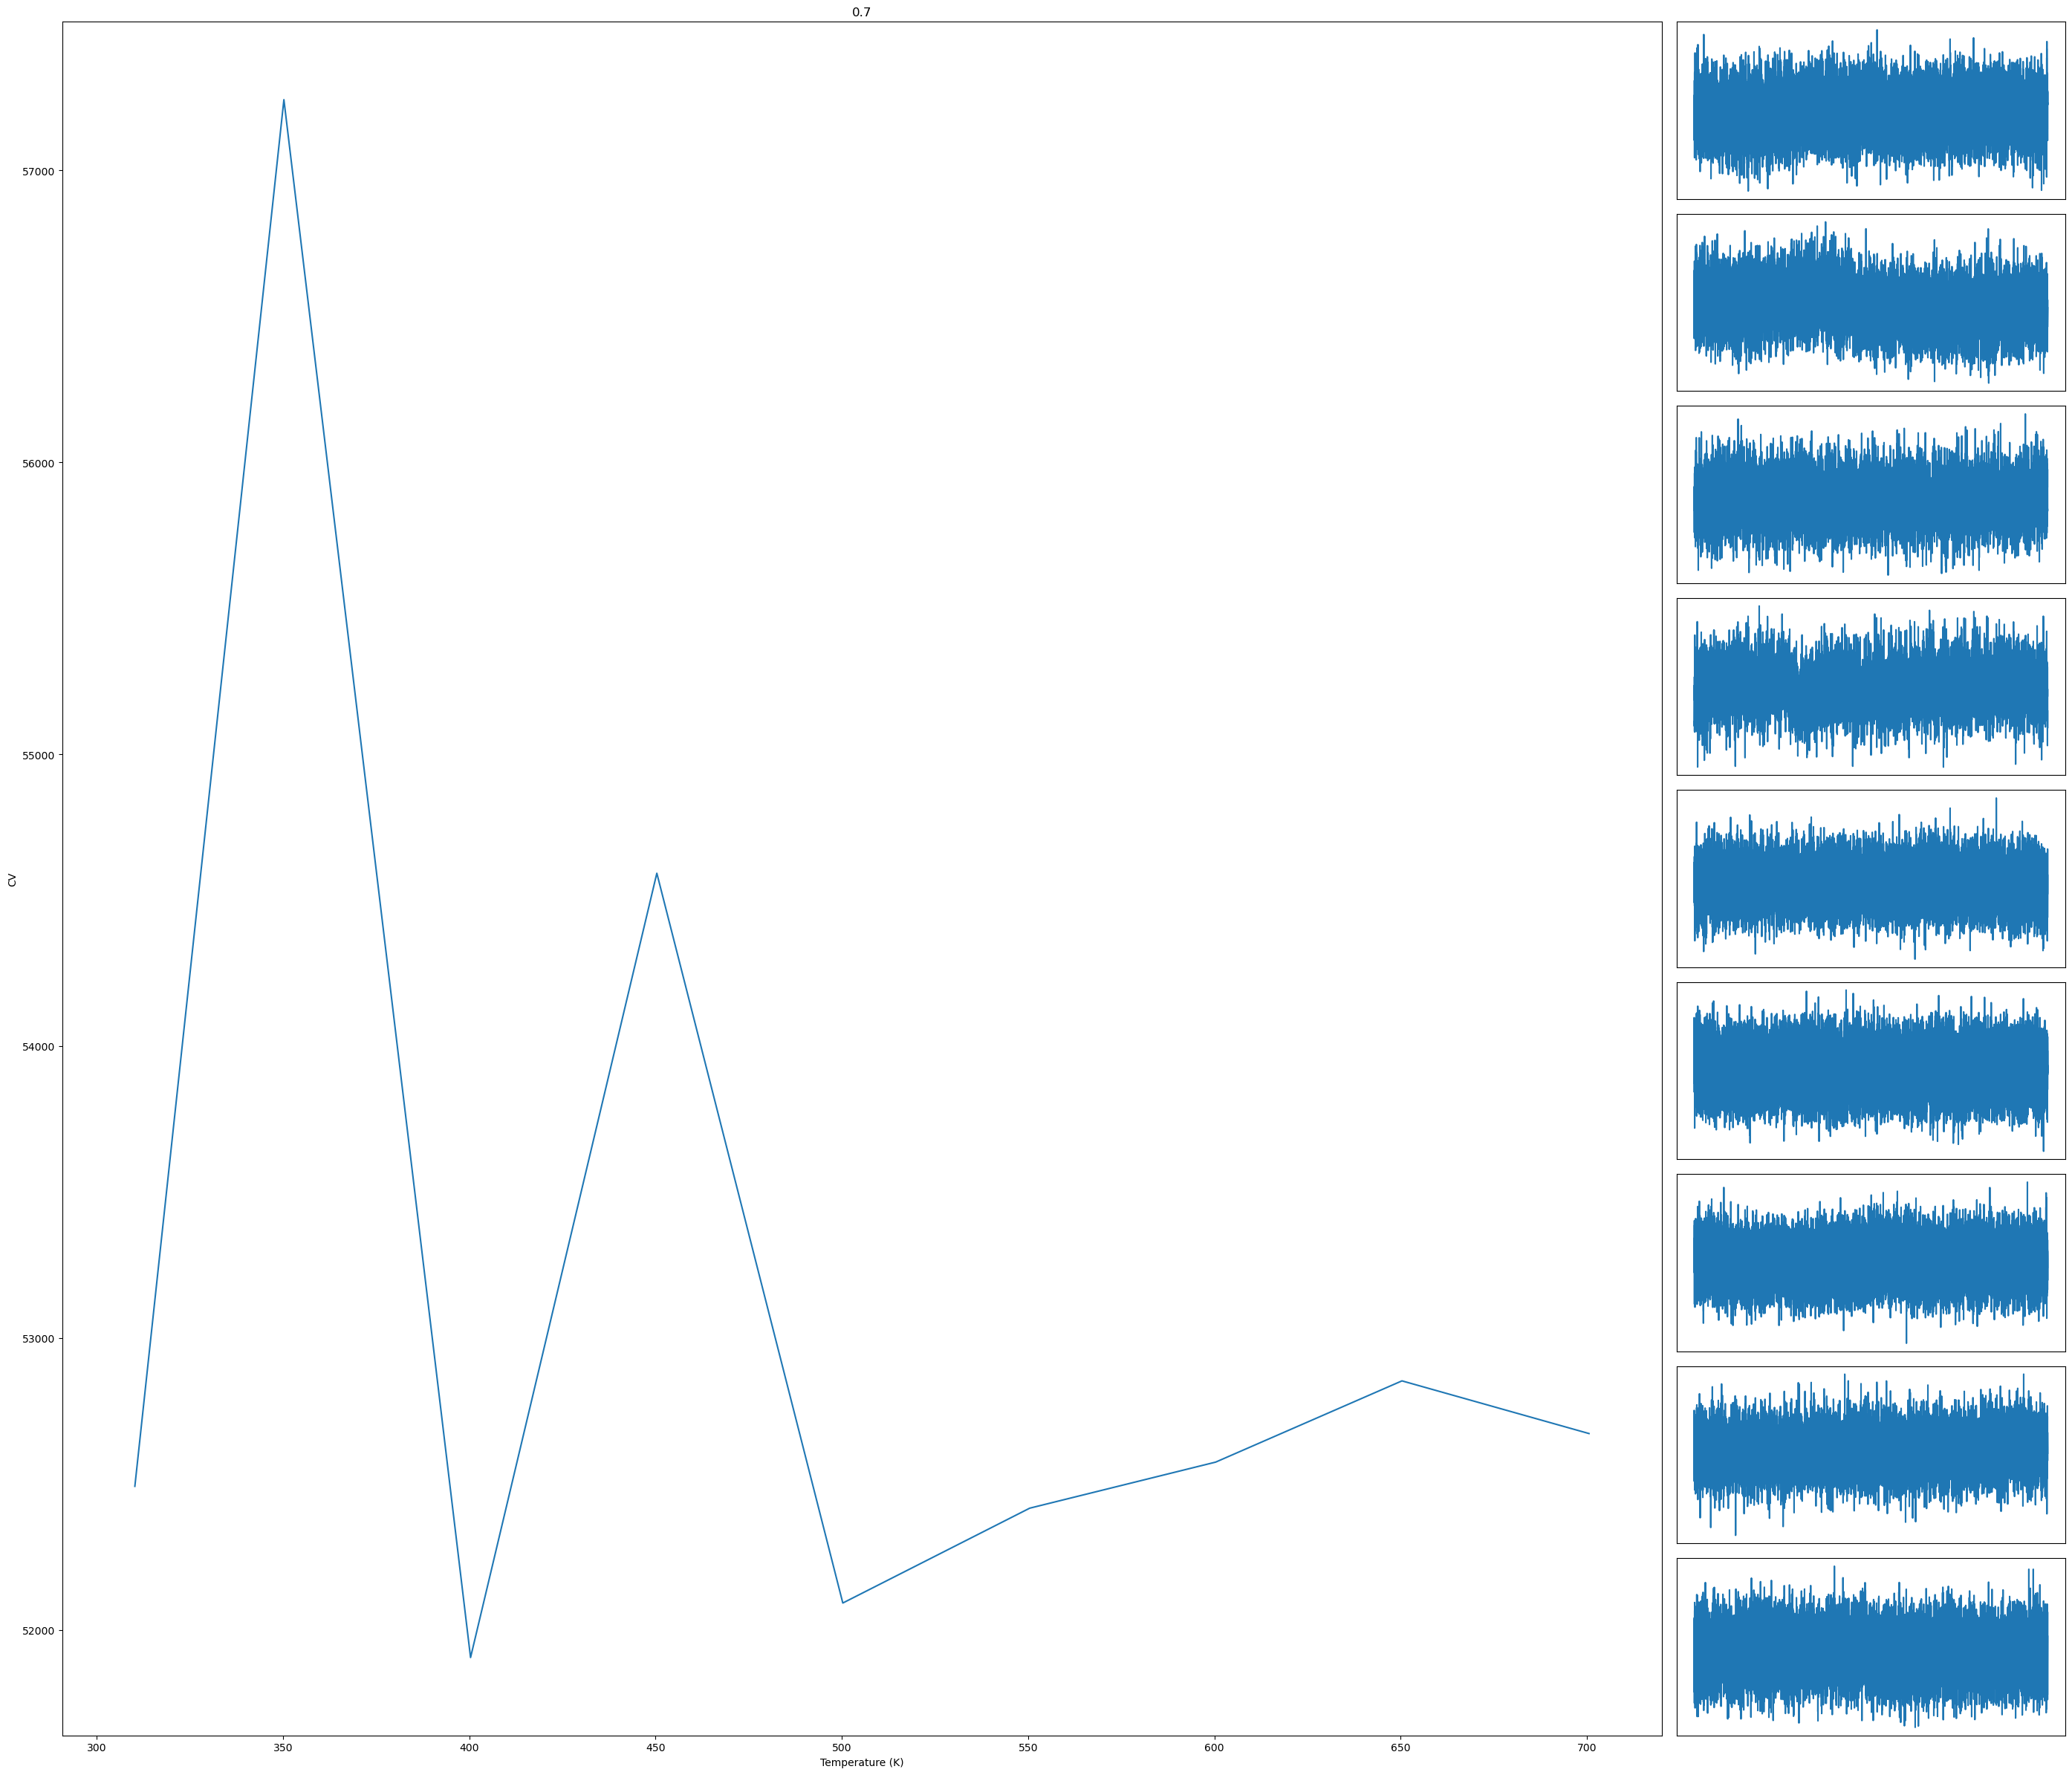

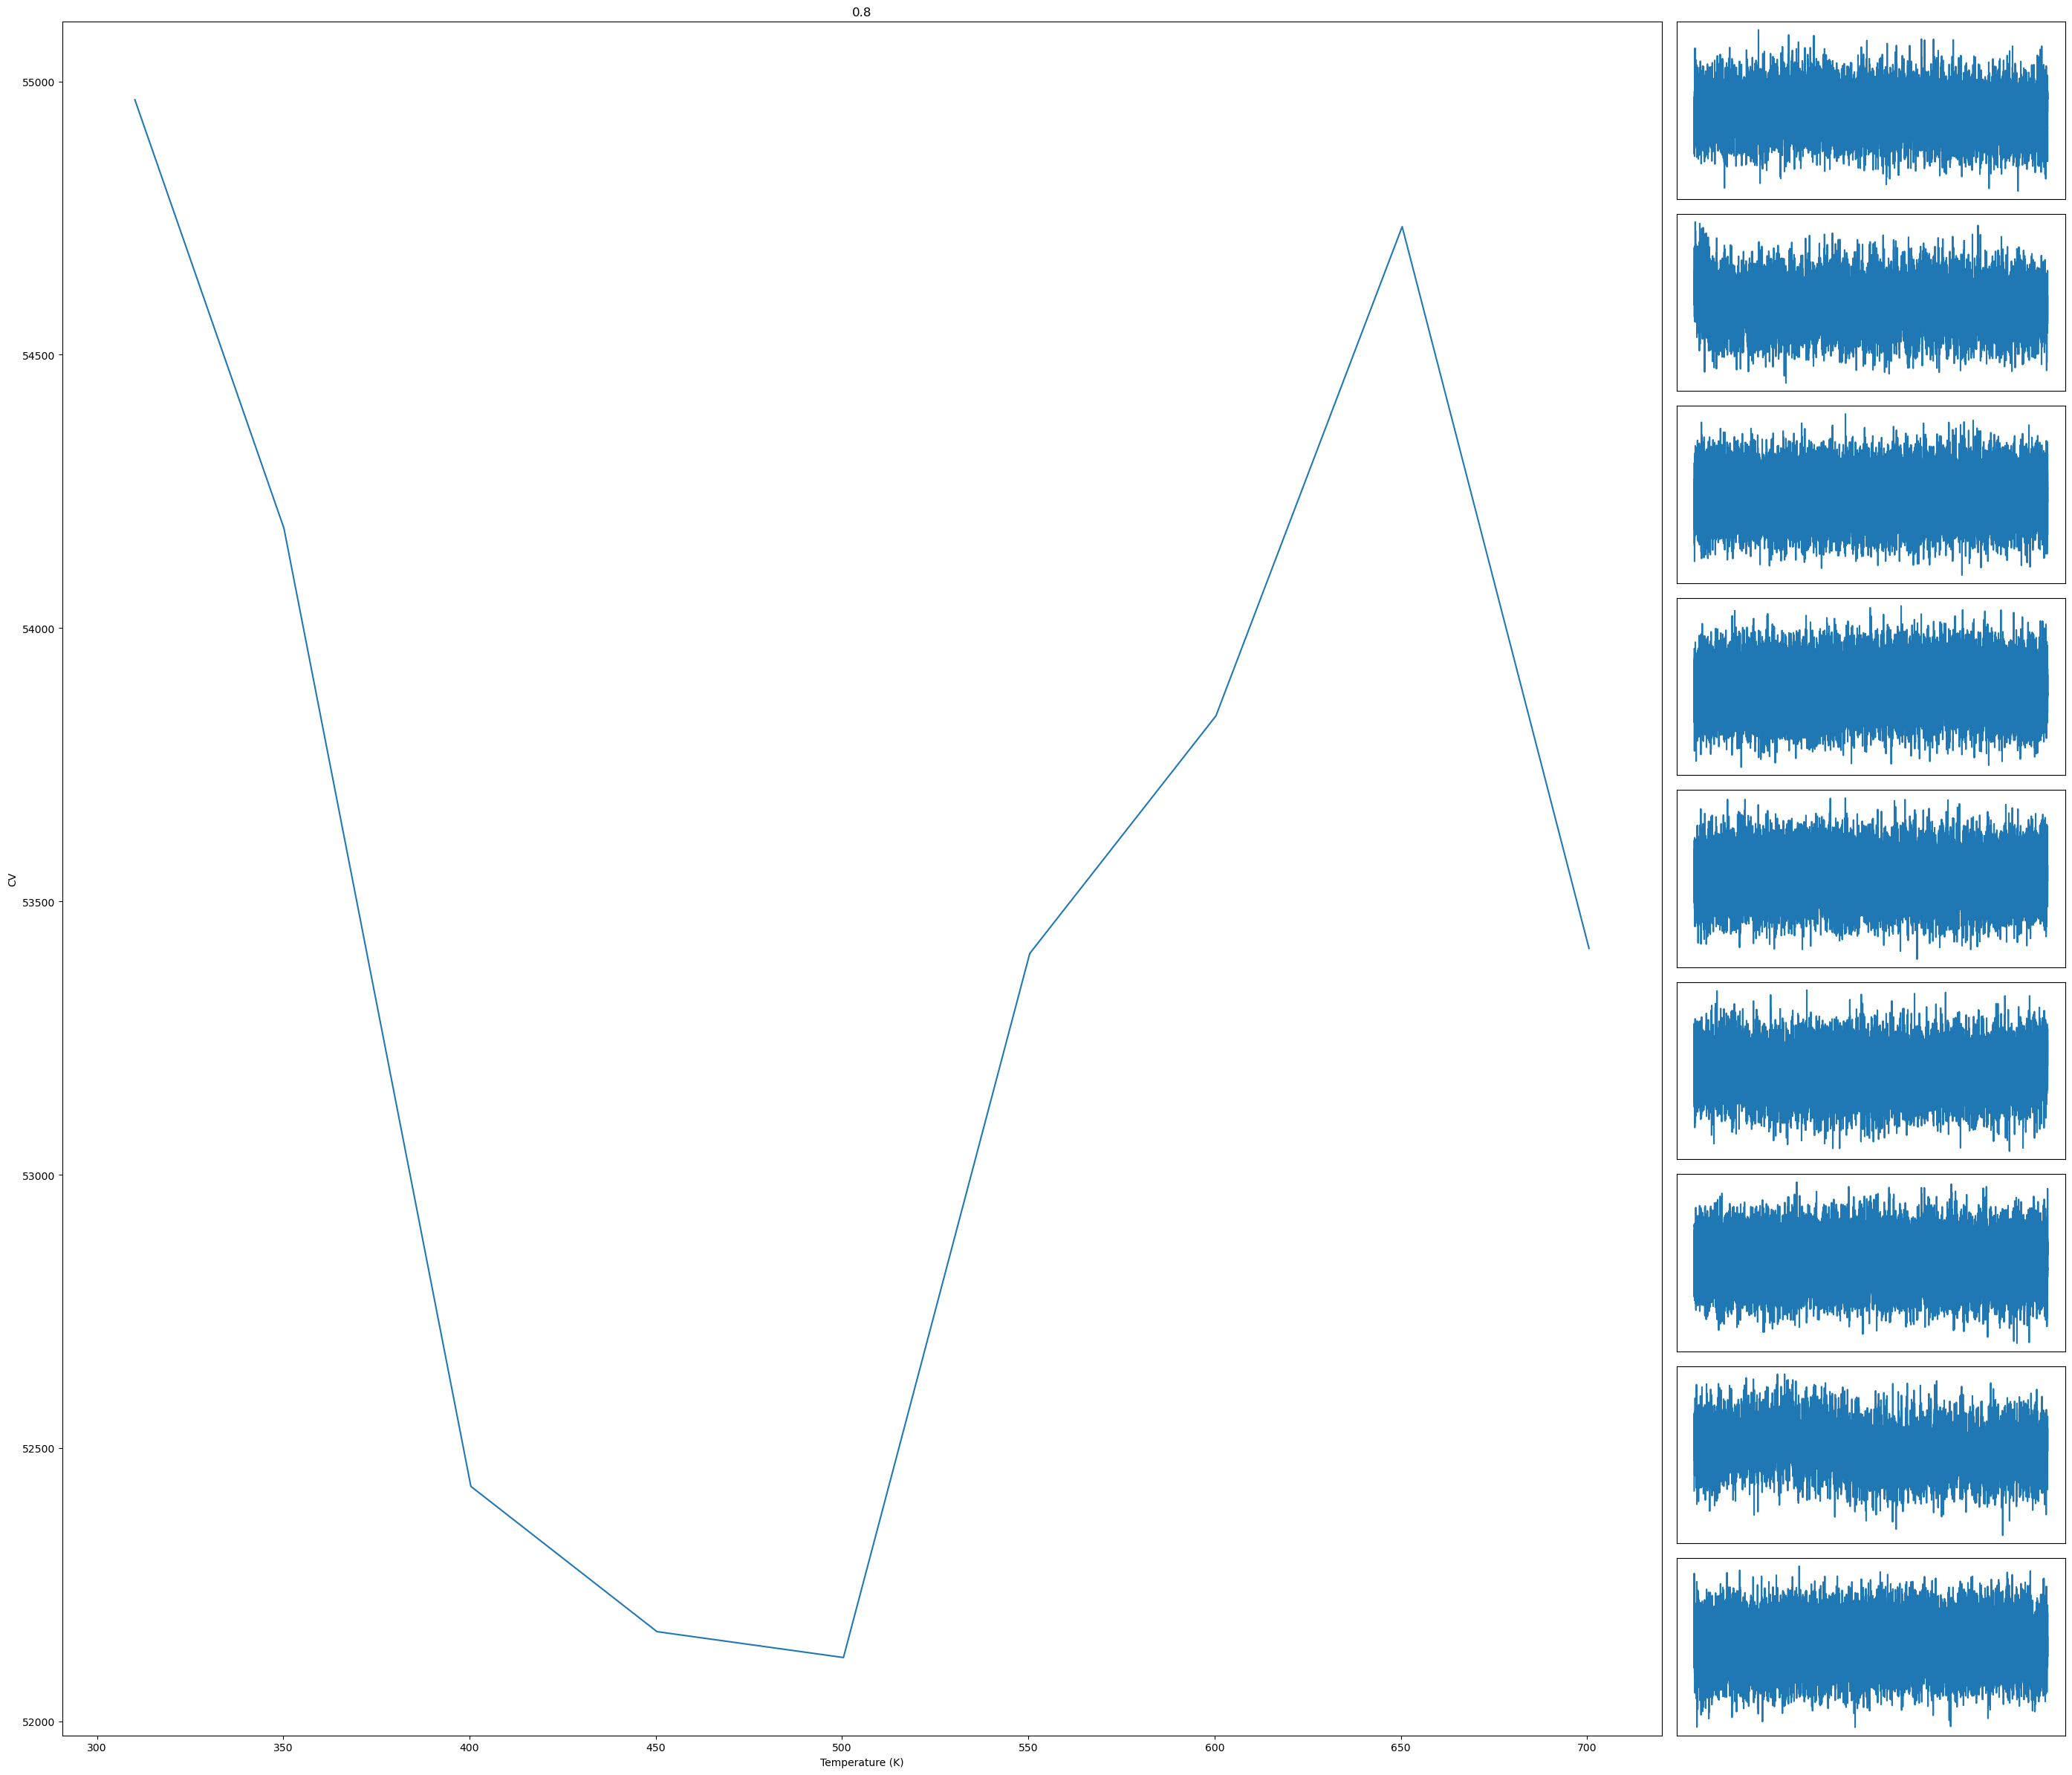

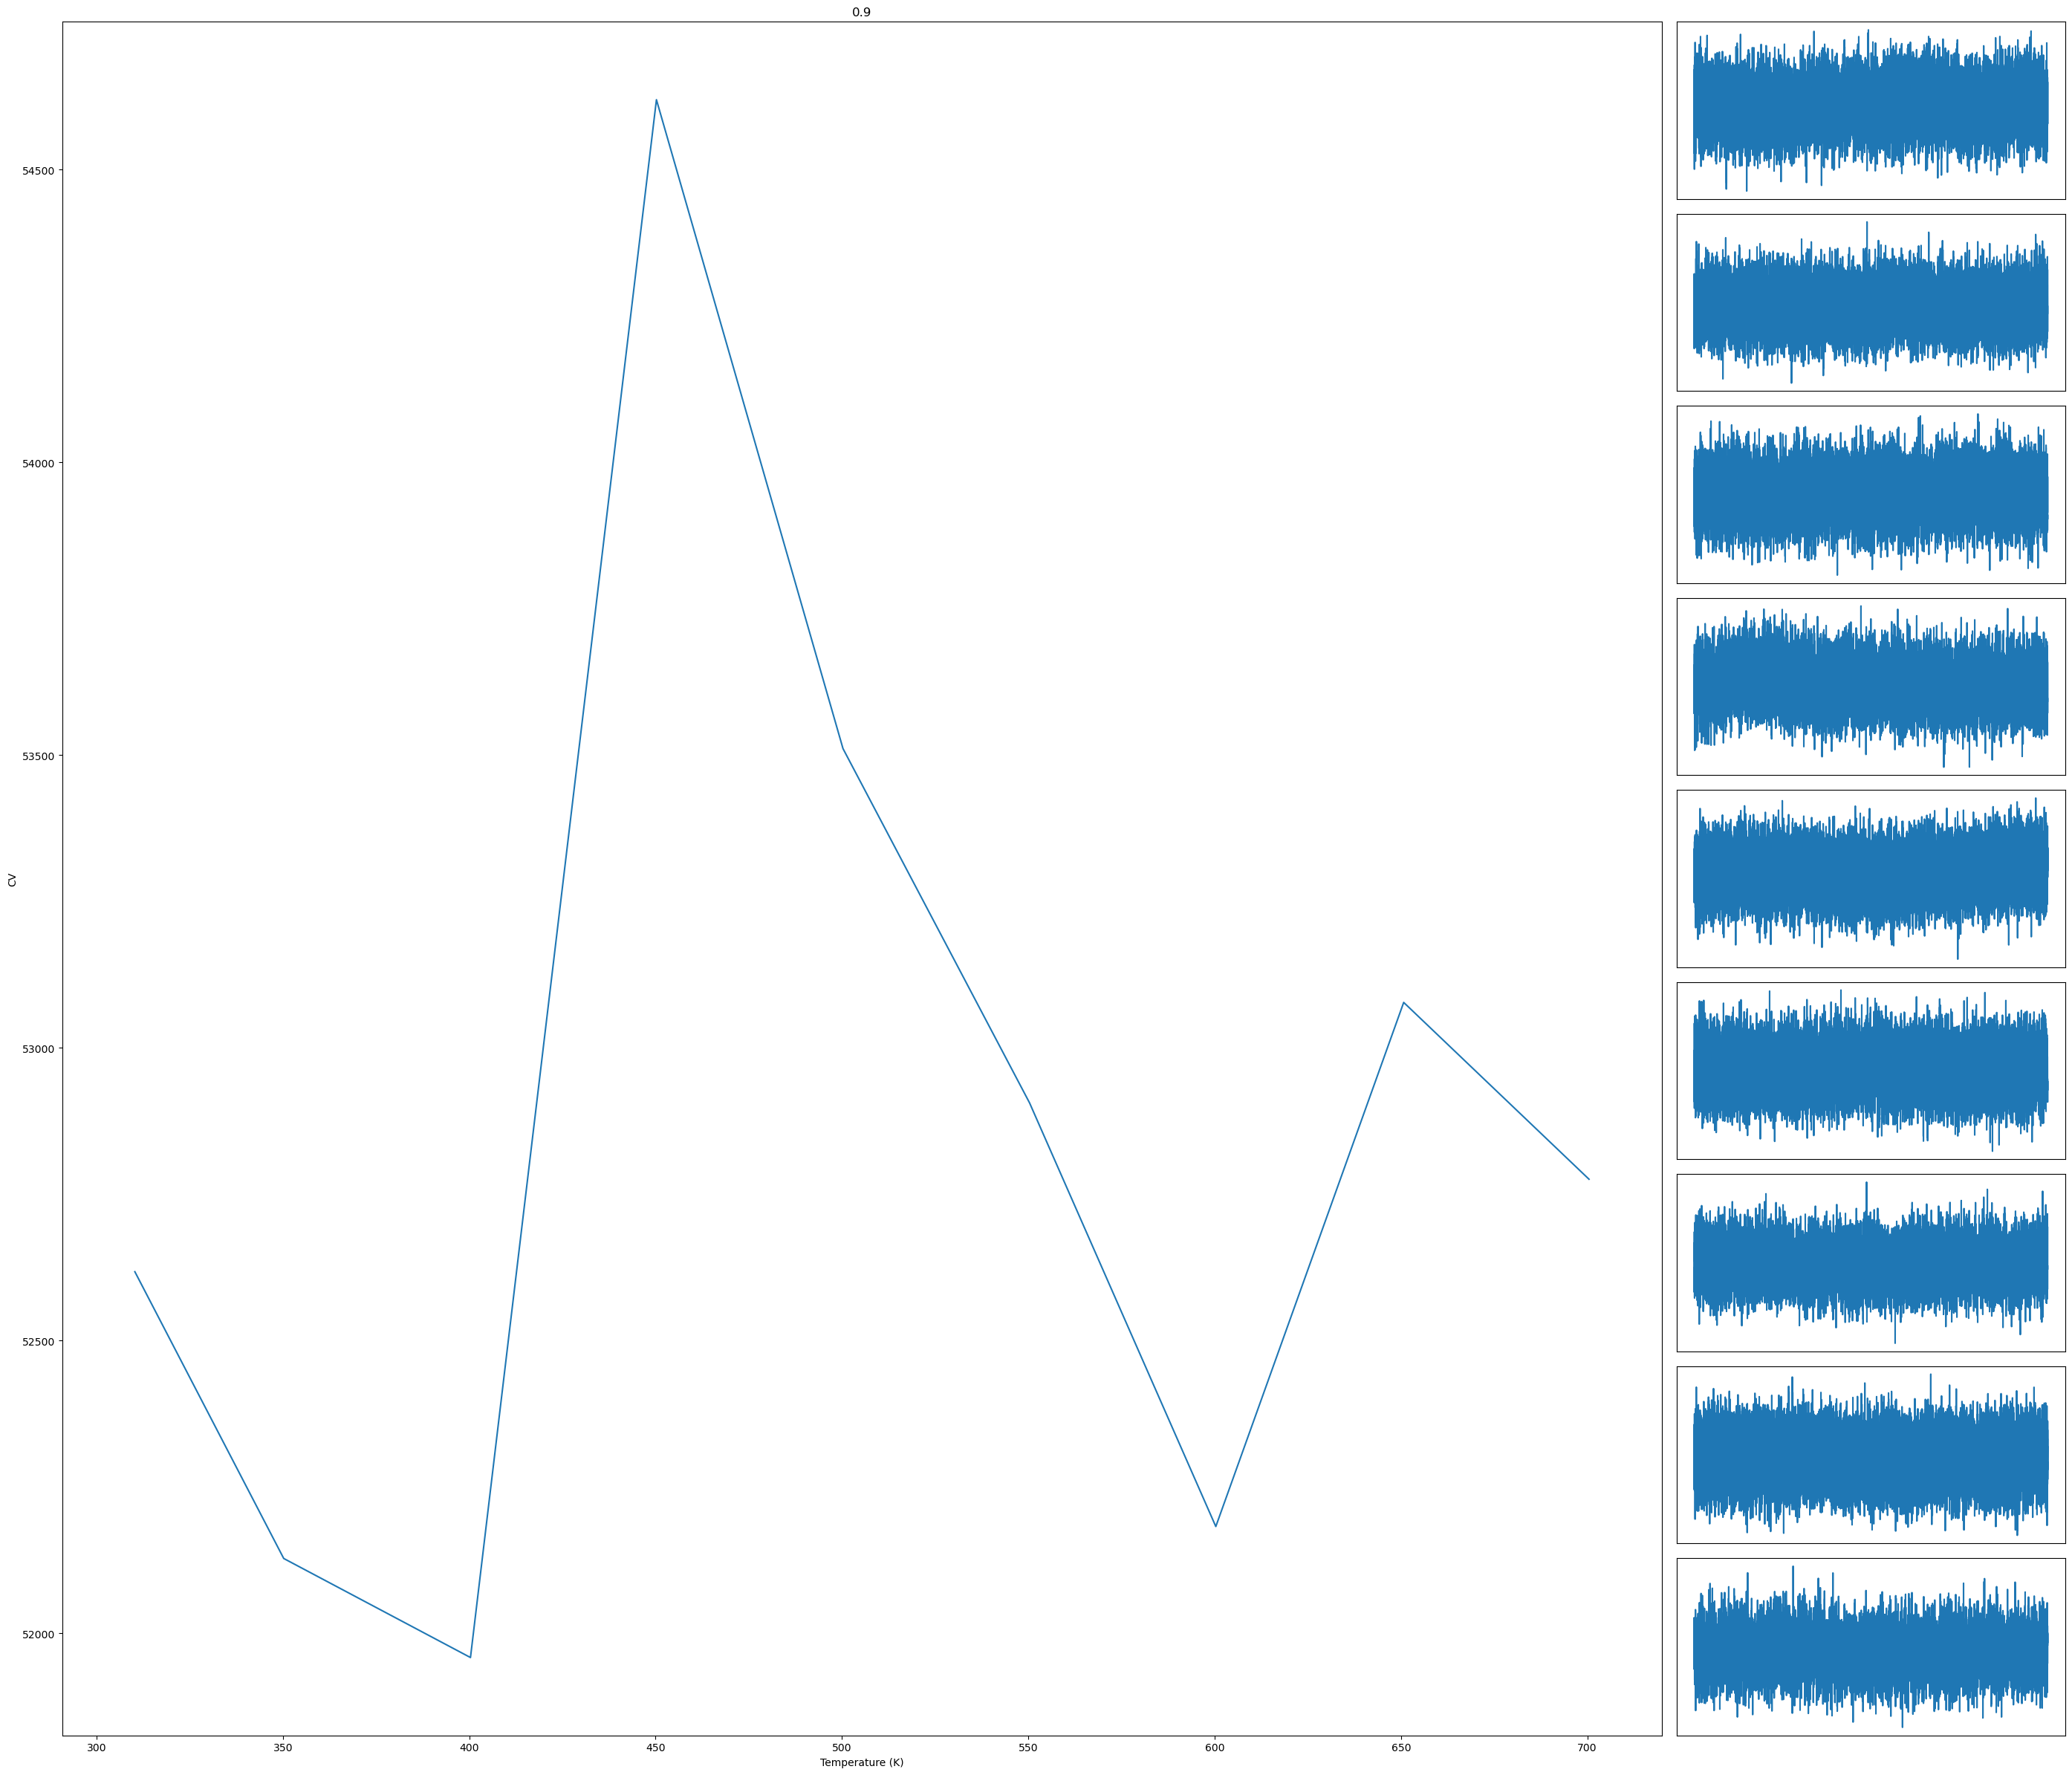

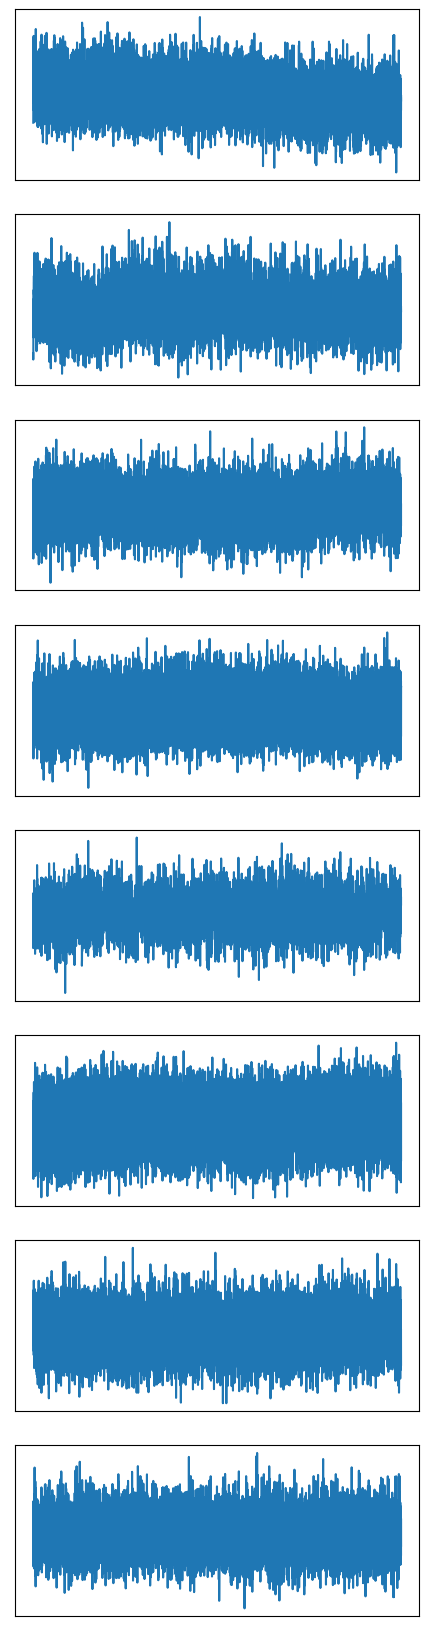

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf

# In[2]:


NA = 6.02214e+23
KB = 1.380649e-23 # KB in joules

kcalToJoule = 4184

dataColumnTitles = [
    "Step",
    "Temperature",
    "Potential_Energy",
    "Kinetic_Energy",
    "Total_Energy"
]

finalDF = pd.DataFrame(
   {
      "Temperature": [],
      "Hbond" : [],
      "CV": []
   }
    
)
dtype0={"Temperature":"float64","Hbond":"float64","CV":"float64"}
tempsArray = [310, 350, 400, 450, 500, 550, 600, 650, 700]
hbondsArray = ["0.00", "0.05", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
indexOfFinalRun = len(tempsArray) * len(hbondsArray) -1

# In[3]:
storedhbondindex = 0
figCount=0
ax = []
tempy=0
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.figure(figsize=(28, 24), dpi=100)

for index in range(0, indexOfFinalRun):
    hbondIndex = index // len(tempsArray)
    tempIndex = index % len(tempsArray)
    temp = tempsArray[tempIndex]
    hbond = hbondsArray[hbondIndex]
    
    logFileName = "./50ns_no_ramp_thermo_data/2beg_" + hbond + "_1.0_" + str(temp) + "1.csv"
    print(logFileName)
    #logFileName = "./2beg_5s_0.05_1.0_400/cv1.csv"
    data = pd.read_csv(logFileName, header=None)
    

    
    # In[4]:
    
    
    # Format data and consider only points after ACF has crossed y=0 with lags=len(data)
    data.columns = dataColumnTitles
    data = data[data["Total_Energy"].notna()]
    acfDataPoints = data[['Step', 'Total_Energy']].set_index(['Step'])
    acfLags = len(acfDataPoints) - 1
    acfResult = acf(acfDataPoints,nlags=acfLags)
    acfCrossing = np.where(np.diff(np.sign(acfResult)))[0][0]
    #data = data.loc[acfCrossing::]
    data = data.loc[round(acfCrossing*1.6):round(len(data['Total_Energy'])*0.8)]
    if (storedhbondindex != hbondIndex):
        figCount += 1
        
        storedhbondindex = hbondIndex
        oneStage = finalDF[finalDF["Hbond"] == float(hbondsArray[hbondIndex-1])]
        ax.append(plt.subplot2grid((len(tempsArray),10),(0,0),colspan=len(tempsArray)-1, rowspan=10))
        ax[tempy].plot(oneStage['Temperature'],oneStage['CV'])  
        ax[tempy].set_title(hbondsArray[hbondIndex-1])
        ax[tempy].set_xlabel("Temperature (K)")
        ax[tempy].set_ylabel("CV")
        plt.tight_layout()
        plt.savefig(str(storedhbondindex).zfill(3) + ".png",dpi=100)
        plt.figure(figsize=(28, 24), dpi=100)
        tempy=0
        ax = []

    ax.append(plt.subplot2grid((len(tempsArray),10),(tempy,8),colspan=2, rowspan=1))
    ax[tempy].plot(data['Total_Energy'])
    #ax[tempy].set_title(tempsArray[tempy])
    ax[tempy].get_xaxis().set_visible(False)
    ax[tempy].get_yaxis().set_visible(False)
    tempy += 1
        
    calcDF = pd.DataFrame(
        {
            'Step': data['Step'],
            'Temperature' : data['Temperature'],
            'Total_Energy (kcal/mol)': data['Total_Energy']
        }
    )
    
    
    # $$C_V = \frac{\langle E^2 \rangle -{\langle E \rangle }^2}{k_BT^2}$$
    
    # In[ ]:
    
    
    calcDF['Total_Energy (J/mol)'] = calcDF['Total_Energy (kcal/mol)'] * kcalToJoule
    calcDF['Total_Energy (J/mol)^2'] = calcDF['Total_Energy (J/mol)'] ** 2
    
    averageTotalEnergy = calcDF['Total_Energy (J/mol)'].mean()
    averageTotalEnergy2 = calcDF['Total_Energy (J/mol)^2'].mean()
    averageTemperature = calcDF['Temperature'].mean()
    
    
    # In[ ]:
    
    
    CV = (averageTotalEnergy2 - (averageTotalEnergy ** 2)) / (KB * NA * (temp) ** 2)
   
    finalDF.loc[index] = [averageTemperature, float(hbond), CV]
   
finalDF.astype(dtype0)
finalDF.to_csv("final.csv",index=False)



In [2]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.contour3D(tempsArray,[float(x) for x in hbondsArray],finalDF['CV'].to_numpy().reshape(len(hbondsArray),len(tempsArray)),1000)
#plt.show()